# Hybrid Topic Discovery and Classification

This notebook implements a hybrid approach that combines similarity-based classification with clustering-based topic discovery.

**Workflow:**
1. Load existing topic-questions.csv (Elder Edwards' curated topics) and new student questions
2. **Similarity Filtering**: For each new question, find best match using cosine similarity
   - If similarity ≥ threshold: Save to File 1 and remove from processing
   - If similarity < threshold: Keep for clustering
3. **Topic Discovery**: Run clustering pipeline on remaining questions
   - Generate embeddings → Reduce dimensions → Cluster → Generate topics
4. **Output Generation**: Generate two files for Elder Edwards' review

**Key Features:**
- Configurable similarity threshold and processing modes
- Advanced caching system for embeddings
- GPT-5 nano/mini integration for topic naming
- Comprehensive error handling and progress tracking
- Production-ready logging and monitoring

---

# Hybrid Topic Discovery and Classification

This notebook implements a hybrid approach that combines similarity-based classification with clustering-based topic discovery.

**Workflow:**
1. Load existing topic-questions.csv (Elder Edwards' curated topics) and new student questions
2. **Similarity Filtering**: For each new question, find best match using cosine similarity
   - If similarity ≥ threshold: Save to File 1 and remove from processing
   - If similarity < threshold: Keep for clustering
3. **Topic Discovery**: Run clustering pipeline on remaining questions
   - Generate embeddings → Reduce dimensions → Cluster → Generate topics
4. **Output Generation**: Generate three files for review: similar questions, new topics, and a full review file.
5. **S3 Upload**: **Delete existing files in the S3 bucket** and upload the newly generated output files to S3.

**Key Features:**
- Configurable similarity threshold and processing modes
- Advanced caching system for embeddings
- GPT-5 nano/mini integration for topic naming
- Comprehensive error handling and progress tracking
- Production-ready logging and monitoring

* * *


## Install Dependencies

In [ ]:
!pip install openai pandas numpy scipy scikit-learn matplotlib seaborn tqdm umap-learn hdbscan bertopic backoff boto3 pyarrow fastparquet gspread google-auth google-auth-oauthlib python-dotenv

## Configuration & Environment Setup

In [ ]:
# ====================================================================
# CONFIGURATION SETTINGS
# ====================================================================

# Processing mode settings
EVAL_MODE = "sample"  # Options: "sample" or "all"
SAMPLE_SIZE = 1000     # Number of questions to evaluate in sample mode

# Similarity filtering settings
SIMILARITY_THRESHOLD = 0.70  # Minimum similarity to match existing topics
REPRESENTATIVE_QUESTION_METHOD = "centroid"  # Options: "centroid" or "frequent"

# OpenAI and GPT settings
EMBEDDING_MODEL = "text-embedding-3-small"
EMBEDDING_DIMENSIONS = 1536  # Default for text-embedding-3-small
GPT_MODEL = "gpt-4o-mini"  # Updated to use gpt-4o-mini

# Caching settings
CACHE_EMBEDDINGS = True
CACHE_DIR = "/content/drive/MyDrive/embeddings_cache"  # Google Drive cache location

# Clustering settings
UMAP_N_COMPONENTS = 5
HDBSCAN_MIN_CLUSTER_SIZE = 3  # Tighter clusters (was 15)
RANDOM_SEED = 42

# AWS S3 Configuration
S3_BUCKET_NAME = "byupathway-public"
S3_PREFIX = "topic-modeling-data"  # Folder within bucket
S3_REGION = "us-east-1"

# Google Sheets Configuration - Environment Responsive
# Tries to load from secrets/env, falls back to default
try:
    from google.colab import userdata
    GOOGLE_SHEETS_URL = userdata.get('GOOGLE_SHEETS_URL', 
        "https://docs.google.com/spreadsheets/d/1L3kOmE6mZEVotjUu2ZuLqir2rZ4c0yfNeeTuHwf3JQI/edit?gid=0#gid=0")
except:
    import os
    GOOGLE_SHEETS_URL = os.getenv('GOOGLE_SHEETS_URL', 
        "https://docs.google.com/spreadsheets/d/1L3kOmE6mZEVotjUu2ZuLqir2rZ4c0yfNeeTuHwf3JQI/edit?gid=0#gid=0")

# Output file format
OUTPUT_FORMAT = "parquet"  # Options: "parquet" or "csv"

# Default visible columns for Streamlit (metadata)
DEFAULT_VISIBLE_COLUMNS = ["question", "timestamp", "country", "state"]

# Logging configuration
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Error logging file
ERROR_LOG_FILE = f"error_log_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.txt"

print(f"📋 CONFIGURATION:")
print(f"   Processing mode: {EVAL_MODE.upper()}")
print(f"   Sample size: {SAMPLE_SIZE if EVAL_MODE == 'sample' else 'ALL'}")
print(f"   Similarity threshold: {SIMILARITY_THRESHOLD}")
print(f"   Representative question method: {REPRESENTATIVE_QUESTION_METHOD}")
print(f"   Embedding model: {EMBEDDING_MODEL}")
print(f"   GPT model: {GPT_MODEL}")
print(f"   Caching: {'ENABLED' if CACHE_EMBEDDINGS else 'DISABLED'}")
print(f"   Output format: {OUTPUT_FORMAT.upper()}")
print(f"   S3 Bucket: {S3_BUCKET_NAME}/{S3_PREFIX}")
print(f"   Google Sheets URL: {GOOGLE_SHEETS_URL[:50]}..." if len(GOOGLE_SHEETS_URL) > 50 else GOOGLE_SHEETS_URL)
print(f"   Random seed: {RANDOM_SEED}")
print("="*60)

📋 CONFIGURATION:
   Processing mode: SAMPLE
   Sample size: 1000
   Similarity threshold: 0.7
   Representative question method: centroid
   Embedding model: text-embedding-3-small
   GPT model: gpt-5-nano
   Caching: ENABLED
   Random seed: 42


In [ ]:
# ====================================================================
# ENVIRONMENT SETUP - Google Colab Style
# ====================================================================

import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
import json
import pickle
from pathlib import Path
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional, Any
import asyncio
import backoff
import difflib

# Environment detection and API key setup
try:
    # Check if running in Google Colab
    import google.colab
    # Production setup for Google Colab
    from google.colab import userdata
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
    print("🔧 Running in Google Colab - using userdata for API key")
except ImportError:
    # Running locally - use hardcoded key for development/testing
    OPENAI_API_KEY = "your-openai-api-key-here"  # HARDCODED FOR DEVELOPMENT
    print("🔧 Running locally - using hardcoded API key for development")
    print("⚠️  Remember to set your actual API key before running")

# Initialize OpenAI clients
try:
    from openai import OpenAI, AsyncOpenAI, APIStatusError
    client = OpenAI(api_key=OPENAI_API_KEY)
    async_client = AsyncOpenAI(api_key=OPENAI_API_KEY)
    print("✅ OpenAI clients initialized successfully")
except Exception as e:
    print(f"❌ Error initializing OpenAI clients: {e}")
    if "your-openai-api-key-here" in str(OPENAI_API_KEY):
        print("💡 Please set your actual OPENAI_API_KEY")
    else:
        print("💡 Check your API key and network connection")

🔧 Running in Google Colab - using userdata for API key
✅ OpenAI clients initialized successfully


In [ ]:
# ====================================================================
# ERROR LOGGING UTILITIES
# ====================================================================

class ErrorLogger:
    """Centralized error logging with file and console output"""
    
    def __init__(self, log_file: str):
        self.log_file = log_file
        self.errors = []
        self.warnings = []
        self.stats = {
            'rows_dropped_malformed': 0,
            'rows_dropped_invalid_json': 0,
            'rows_dropped_duplicates': 0,
            'rows_dropped_missing_data': 0,
            'embedding_failures': 0,
            'total_rows_processed': 0,
            'total_rows_kept': 0
        }
        
        # Initialize log file
        with open(self.log_file, 'w', encoding='utf-8') as f:
            f.write(f"=== Error Log - {pd.Timestamp.now()} ===\n\n")
    
    def log_error(self, category: str, message: str, details: str = None):
        """Log an error with category and details"""
        timestamp = pd.Timestamp.now()
        error_entry = {
            'timestamp': timestamp,
            'category': category,
            'message': message,
            'details': details
        }
        self.errors.append(error_entry)
        
        # Write to file
        with open(self.log_file, 'a', encoding='utf-8') as f:
            f.write(f"[{timestamp}] ERROR - {category}\n")
            f.write(f"  Message: {message}\n")
            if details:
                f.write(f"  Details: {details}\n")
            f.write("\n")
        
        # Print to console
        print(f"❌ ERROR [{category}]: {message}")
    
    def log_warning(self, category: str, message: str):
        """Log a warning"""
        timestamp = pd.Timestamp.now()
        warning_entry = {
            'timestamp': timestamp,
            'category': category,
            'message': message
        }
        self.warnings.append(warning_entry)
        
        # Write to file
        with open(self.log_file, 'a', encoding='utf-8') as f:
            f.write(f"[{timestamp}] WARNING - {category}\n")
            f.write(f"  Message: {message}\n\n")
        
        # Print to console
        print(f"⚠️  WARNING [{category}]: {message}")
    
    def update_stats(self, stat_name: str, increment: int = 1):
        """Update statistics"""
        if stat_name in self.stats:
            self.stats[stat_name] += increment
    
    def print_summary(self):
        """Print comprehensive error summary"""
        print(f"\n{'='*60}")
        print(f"📊 ERROR LOGGING SUMMARY")
        print(f"{'='*60}")
        
        print(f"\n📈 PROCESSING STATISTICS:")
        print(f"   Total rows processed: {self.stats['total_rows_processed']}")
        print(f"   Total rows kept: {self.stats['total_rows_kept']}")
        print(f"   Success rate: {(self.stats['total_rows_kept']/self.stats['total_rows_processed']*100) if self.stats['total_rows_processed'] > 0 else 0:.2f}%")
        
        print(f"\n🗑️  ROWS DROPPED:")
        print(f"   Malformed data: {self.stats['rows_dropped_malformed']}")
        print(f"   Invalid JSON: {self.stats['rows_dropped_invalid_json']}")
        print(f"   Duplicates: {self.stats['rows_dropped_duplicates']}")
        print(f"   Missing required data: {self.stats['rows_dropped_missing_data']}")
        print(f"   Embedding failures: {self.stats['embedding_failures']}")
        
        total_dropped = sum([
            self.stats['rows_dropped_malformed'],
            self.stats['rows_dropped_invalid_json'],
            self.stats['rows_dropped_duplicates'],
            self.stats['rows_dropped_missing_data']
        ])
        print(f"   Total dropped: {total_dropped}")
        
        print(f"\n❌ ERRORS: {len(self.errors)}")
        if self.errors:
            error_categories = {}
            for err in self.errors:
                category = err['category']
                error_categories[category] = error_categories.get(category, 0) + 1
            for category, count in error_categories.items():
                print(f"   {category}: {count}")
        
        print(f"\n⚠️  WARNINGS: {len(self.warnings)}")
        if self.warnings:
            warning_categories = {}
            for warn in self.warnings:
                category = warn['category']
                warning_categories[category] = warning_categories.get(category, 0) + 1
            for category, count in warning_categories.items():
                print(f"   {category}: {count}")
        
        print(f"\n📁 Log file saved: {self.log_file}")
        print(f"{'='*60}\n")
        
        # Write summary to log file
        with open(self.log_file, 'a', encoding='utf-8') as f:
            f.write(f"\n{'='*60}\n")
            f.write(f"SUMMARY\n")
            f.write(f"{'='*60}\n\n")
            f.write(f"Total rows processed: {self.stats['total_rows_processed']}\n")
            f.write(f"Total rows kept: {self.stats['total_rows_kept']}\n")
            f.write(f"Total rows dropped: {total_dropped}\n")
            f.write(f"Total errors: {len(self.errors)}\n")
            f.write(f"Total warnings: {len(self.warnings)}\n")

# Initialize error logger
error_logger = ErrorLogger(ERROR_LOG_FILE)
print(f"✅ Error logging initialized: {ERROR_LOG_FILE}")

In [ ]:
# ====================================================================
# LANGFUSE DATA CLEANING UTILITIES
# ====================================================================

def clean_langfuse_data(df: pd.DataFrame, error_logger: ErrorLogger) -> pd.DataFrame:
    """
    Clean Langfuse CSV data with comprehensive error handling
    
    Args:
        df: Raw DataFrame from Langfuse CSV
        error_logger: ErrorLogger instance for tracking issues
        
    Returns:
        Cleaned DataFrame with required columns
    """
    print(f"🧹 Starting Langfuse data cleaning...")
    print(f"   Initial rows: {len(df)}")
    
    error_logger.update_stats('total_rows_processed', len(df))
    
    cleaned_rows = []
    
    for idx, row in df.iterrows():
        try:
            # Initialize cleaned row dict
            cleaned_row = {}
            
            # === Extract Timestamp ===
            timestamp = row.get('timestamp', None) or row.get('createdAt', None)
            if pd.isna(timestamp):
                error_logger.log_warning('MISSING_DATA', f"Row {idx}: Missing timestamp")
                error_logger.update_stats('rows_dropped_missing_data')
                continue
            cleaned_row['timestamp'] = pd.to_datetime(timestamp)
            
            # === Extract Question (Input) ===
            input_data = row.get('input', '')
            question = None
            
            # Check for kwargs pattern
            if isinstance(input_data, str) and 'kwargs' in input_data:
                try:
                    input_json = json.loads(input_data)
                    # Extract from kwargs.data.messages[0].content
                    if 'kwargs' in input_json and 'data' in input_json['kwargs']:
                        data = input_json['kwargs']['data']
                        if 'messages' in data and len(data['messages']) > 0:
                            question = data['messages'][0].get('content', '')
                except json.JSONDecodeError as e:
                    error_logger.log_error('JSON_PARSE', f"Row {idx}: Failed to parse kwargs JSON", str(e))
                    error_logger.update_stats('rows_dropped_invalid_json')
                    continue
            else:
                # Regular input (direct question string)
                question = input_data if isinstance(input_data, str) else str(input_data)
            
            if not question or pd.isna(question) or question.strip() == '':
                error_logger.log_warning('MISSING_DATA', f"Row {idx}: Missing or empty question")
                error_logger.update_stats('rows_dropped_missing_data')
                continue
            
            # Clean the question (remove ACM prefixes, etc.)
            question = clean_question(question)
            cleaned_row['question'] = question
            
            # === Extract Output ===
            output_data = row.get('output', '')
            if isinstance(output_data, str) and output_data.strip():
                cleaned_row['output'] = output_data
            else:
                # Try to extract from kwargs if available
                if isinstance(input_data, str) and 'kwargs' in input_data:
                    try:
                        input_json = json.loads(input_data)
                        if 'kwargs' in input_json and 'data' in input_json['kwargs']:
                            data = input_json['kwargs']['data']
                            if 'messages' in data and len(data['messages']) > 1:
                                # Second message might be output
                                cleaned_row['output'] = data['messages'][1].get('content', None)
                    except:
                        pass
                
                if 'output' not in cleaned_row or not cleaned_row['output']:
                    cleaned_row['output'] = None
            
            # === Extract User Feedback ===
            user_feedback = row.get('user_feedback', None)
            cleaned_row['user_feedback'] = user_feedback if not pd.isna(user_feedback) else None
            
            # === Extract Metadata (JSON parsing) ===
            metadata_str = row.get('metadata', '{}')
            metadata = {}
            
            if isinstance(metadata_str, str) and metadata_str.strip():
                try:
                    metadata = json.loads(metadata_str)
                except json.JSONDecodeError as e:
                    error_logger.log_warning('JSON_PARSE', f"Row {idx}: Failed to parse metadata JSON, using empty dict")
                    metadata = {}
            
            # Extract specific metadata fields
            cleaned_row['ip_address'] = metadata.get('ip', None)
            cleaned_row['user_language'] = metadata.get('user_language', None)
            cleaned_row['is_suspicious'] = metadata.get('security_validation', {}).get('is_suspicious', False) if isinstance(metadata.get('security_validation'), dict) else False
            
            # Country, State, City - check both metadata and direct columns
            cleaned_row['country'] = metadata.get('country', None) or row.get('country', None)
            cleaned_row['state'] = metadata.get('state', None) or row.get('state', None)
            cleaned_row['city'] = metadata.get('city', None) or row.get('city', None)
            
            # Convert None to proper null for non-existent values
            for key in ['country', 'state', 'city', 'ip_address', 'user_language', 'output', 'user_feedback']:
                if key in cleaned_row and (cleaned_row[key] is None or pd.isna(cleaned_row[key])):
                    cleaned_row[key] = None
            
            cleaned_rows.append(cleaned_row)
            
        except Exception as e:
            error_logger.log_error('ROW_PROCESSING', f"Row {idx}: Unexpected error processing row", str(e))
            error_logger.update_stats('rows_dropped_malformed')
            continue
    
    # Create cleaned DataFrame
    cleaned_df = pd.DataFrame(cleaned_rows)
    
    print(f"   After initial cleaning: {len(cleaned_df)} rows")
    
    # === Remove Duplicates (same timestamp + same question) ===
    print(f"🔍 Checking for duplicates (same timestamp + question)...")
    initial_count = len(cleaned_df)
    
    # Keep first occurrence
    cleaned_df = cleaned_df.drop_duplicates(subset=['timestamp', 'question'], keep='first')
    
    duplicates_removed = initial_count - len(cleaned_df)
    if duplicates_removed > 0:
        print(f"   Removed {duplicates_removed} duplicate rows")
        error_logger.update_stats('rows_dropped_duplicates', duplicates_removed)
    
    # === Update final stats ===
    error_logger.update_stats('total_rows_kept', len(cleaned_df))
    
    print(f"✅ Data cleaning complete!")
    print(f"   Final rows: {len(cleaned_df)}")
    print(f"   Rows dropped: {error_logger.stats['total_rows_processed'] - len(cleaned_df)}")
    
    # Show column summary
    print(f"\n📊 Cleaned data summary:")
    print(f"   Columns: {list(cleaned_df.columns)}")
    print(f"   Date range: {cleaned_df['timestamp'].min()} to {cleaned_df['timestamp'].max()}")
    print(f"   Countries: {cleaned_df['country'].nunique()} unique")
    print(f"   Questions with output: {cleaned_df['output'].notna().sum()}")
    print(f"   Questions with user feedback: {cleaned_df['user_feedback'].notna().sum()}")
    
    return cleaned_df

def clean_question(question: str) -> str:
    """
    Remove ACM question prefix and other cleaning operations
    """
    if not isinstance(question, str):
        return str(question) if question is not None else ""
    
    import re
    
    # Remove ACM prefixes
    pattern = r'^\s*\(ACMs?\s+[Qq]uestion\)\s*:?\s*'
    cleaned = re.sub(pattern, '', question, flags=re.IGNORECASE).strip()
    
    # Additional cleaning: remove extra whitespace
    cleaned = ' '.join(cleaned.split())
    
    return cleaned if cleaned else question

print("✅ Langfuse data cleaning utilities loaded!")

In [ ]:
# ====================================================================
# GOOGLE SHEETS INTEGRATION
# ====================================================================

def get_google_sheets_credentials():
    """
    Get Google Sheets credentials from Colab secrets or environment
    """
    try:
        # Try Google Colab secrets first
        import google.colab
        from google.colab import userdata
        from google.oauth2.service_account import Credentials
        
        print("🔧 Attempting to load Google Sheets credentials from Colab secrets...")
        
        # Try to construct credentials from individual secrets
        try:
            credentials_dict = {
                "type": userdata.get('GOOGLE_SERVICE_ACCOUNT_TYPE'),
                "project_id": userdata.get('GOOGLE_SERVICE_ACCOUNT_PROJECT_ID'),
                "private_key_id": userdata.get('GOOGLE_SERVICE_ACCOUNT_PRIVATE_KEY_ID'),
                "private_key": userdata.get('GOOGLE_SERVICE_ACCOUNT_PRIVATE_KEY').replace('\\n', '\n'),
                "client_email": userdata.get('GOOGLE_SERVICE_ACCOUNT_CLIENT_EMAIL'),
                "client_id": userdata.get('GOOGLE_SERVICE_ACCOUNT_CLIENT_ID'),
                "auth_uri": "https://accounts.google.com/o/oauth2/auth",
                "token_uri": "https://oauth2.googleapis.com/token",
                "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
                "client_x509_cert_url": userdata.get('GOOGLE_SERVICE_ACCOUNT_CLIENT_CERT_URL'),
                "universe_domain": "googleapis.com"
            }
            
            scopes = [
                'https://www.googleapis.com/auth/spreadsheets',
                'https://www.googleapis.com/auth/drive'
            ]
            
            credentials = Credentials.from_service_account_info(credentials_dict, scopes=scopes)
            print("✅ Credentials loaded from Colab secrets")
            return credentials
            
        except Exception as e:
            print(f"⚠️  Failed to load from Colab secrets: {e}")
            return None
            
    except ImportError:
        # Not in Colab, try local environment
        print("🔧 Not in Colab environment, checking for local credentials...")
        
        try:
            from dotenv import load_dotenv
            load_dotenv()
            
            # Check if environment variables are set
            if os.getenv('GOOGLE_SERVICE_ACCOUNT_TYPE'):
                from google.oauth2.service_account import Credentials
                
                credentials_dict = {
                    "type": os.getenv('GOOGLE_SERVICE_ACCOUNT_TYPE'),
                    "project_id": os.getenv('GOOGLE_SERVICE_ACCOUNT_PROJECT_ID'),
                    "private_key_id": os.getenv('GOOGLE_SERVICE_ACCOUNT_PRIVATE_KEY_ID'),
                    "private_key": os.getenv('GOOGLE_SERVICE_ACCOUNT_PRIVATE_KEY').replace('\\n', '\n'),
                    "client_email": os.getenv('GOOGLE_SERVICE_ACCOUNT_CLIENT_EMAIL'),
                    "client_id": os.getenv('GOOGLE_SERVICE_ACCOUNT_CLIENT_ID'),
                    "auth_uri": "https://accounts.google.com/o/oauth2/auth",
                    "token_uri": "https://oauth2.googleapis.com/token",
                    "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
                    "client_x509_cert_url": os.getenv('GOOGLE_SERVICE_ACCOUNT_CLIENT_CERT_URL'),
                    "universe_domain": "googleapis.com"
                }
                
                scopes = [
                    'https://www.googleapis.com/auth/spreadsheets',
                    'https://www.googleapis.com/auth/drive'
                ]
                
                credentials = Credentials.from_service_account_info(credentials_dict, scopes=scopes)
                print("✅ Credentials loaded from environment variables")
                return credentials
            
            # Try JSON file
            creds_path = os.getenv('GOOGLE_SHEETS_CREDENTIALS_PATH', 'credentials/byu-pathway-chatbot-service-account.json')
            if os.path.exists(creds_path):
                from google.oauth2.service_account import Credentials
                scopes = [
                    'https://www.googleapis.com/auth/spreadsheets',
                    'https://www.googleapis.com/auth/drive'
                ]
                credentials = Credentials.from_service_account_file(creds_path, scopes=scopes)
                print(f"✅ Credentials loaded from file: {creds_path}")
                return credentials
            
            print("❌ No credentials found in environment or file")
            return None
            
        except Exception as e:
            print(f"❌ Failed to load credentials: {e}")
            return None

def read_topics_from_google_sheets(sheet_url: str) -> pd.DataFrame:
    """
    Read topic-subtopic-question data from Google Sheets
    
    Args:
        sheet_url: URL of the Google Sheet
        
    Returns:
        DataFrame with columns: topic, subtopic, question
    """
    import gspread
    
    print(f"📊 Reading topics from Google Sheets...")
    
    credentials = get_google_sheets_credentials()
    if credentials is None:
        raise Exception("Failed to get Google Sheets credentials")
    
    # Initialize gspread client
    client = gspread.authorize(credentials)
    
    # Extract spreadsheet ID from URL
    import re
    match = re.search(r'/spreadsheets/d/([a-zA-Z0-9-_]+)', sheet_url)
    if not match:
        raise ValueError(f"Invalid Google Sheets URL: {sheet_url}")
    
    spreadsheet_id = match.group(1)
    
    # Open the spreadsheet
    try:
        spreadsheet = client.open_by_key(spreadsheet_id)
        worksheet = spreadsheet.get_worksheet(0)  # Get first worksheet
        
        # Get all values
        data = worksheet.get_all_values()
        
        if not data:
            raise ValueError("Google Sheet is empty")
        
        # Convert to DataFrame (first row is header)
        df = pd.DataFrame(data[1:], columns=data[0])
        
        print(f"✅ Successfully read {len(df)} rows from Google Sheets")
        print(f"   Columns: {list(df.columns)}")
        
        # Validate required columns
        required_columns = ['topic', 'subtopic', 'question']
        missing_columns = [col for col in required_columns if col not in df.columns]
        
        if missing_columns:
            # Try case-insensitive matching
            df.columns = [col.lower().strip() for col in df.columns]
            missing_columns = [col for col in required_columns if col not in df.columns]
            
            if missing_columns:
                raise ValueError(f"Missing required columns: {missing_columns}")
        
        # Clean data
        df = df[required_columns].copy()
        df = df[df['question'].notna() & (df['question'] != '')]  # Remove empty questions
        
        print(f"   Topics: {df['topic'].nunique()} unique")
        print(f"   Subtopics: {df['subtopic'].nunique()} unique")
        print(f"   Questions: {len(df)}")
        
        return df
        
    except Exception as e:
        raise Exception(f"Failed to read Google Sheet: {e}")

print("✅ Google Sheets integration loaded!")

## Question Cleaning and Preprocessing

In [ ]:
# ====================================================================
# QUESTION PREPROCESSING UTILITIES
# ====================================================================

# Note: clean_question function is now defined in Langfuse data cleaning utilities section

def preprocess_questions_dataframe(df: pd.DataFrame, question_column: str = 'question') -> pd.DataFrame:
    """
    Apply question cleaning to a DataFrame containing questions.

    Args:
        df (pd.DataFrame): DataFrame containing questions
        question_column (str): Name of the column containing questions

    Returns:
        pd.DataFrame: DataFrame with cleaned questions
    """
    if df is None or len(df) == 0:
        return df

    df_cleaned = df.copy()

    # Count questions with ACM prefix before cleaning
    acm_pattern = r'^\s*\(ACMs?\s+[Qq]uestion\)'
    acm_questions_count = df_cleaned[question_column].str.contains(acm_pattern, na=False, regex=True).sum()

    if acm_questions_count > 0:
        print(f"🔧 Found {acm_questions_count} questions with ACM prefix - cleaning before processing...")

        # Show examples before cleaning
        acm_examples = df_cleaned[df_cleaned[question_column].str.contains(acm_pattern, na=False, regex=True)][question_column].head(3).tolist()
        print(f"📋 Examples of ACM questions before cleaning:")
        for i, example in enumerate(acm_examples, 1):
            print(f"   {i}. \"{example}\"")

    # Apply cleaning function
    df_cleaned[question_column] = df_cleaned[question_column].apply(clean_question)

    if acm_questions_count > 0:
        # Show examples after cleaning
        acm_examples_cleaned = [clean_question(q) for q in acm_examples]
        print(f"📋 Examples after cleaning:")
        for i, (original, cleaned) in enumerate(zip(acm_examples, acm_examples_cleaned), 1):
            print(f"   {i}. \"{cleaned}\"")
        print(f"✅ Cleaned {acm_questions_count} ACM questions")
    else:
        print(f"ℹ️  No ACM prefixes found in questions")

    return df_cleaned

print("🔧 Question preprocessing utilities loaded!")

🔧 Question preprocessing utilities loaded!


## Google Drive Setup (for caching)

In [ ]:
# ====================================================================
# GOOGLE DRIVE SETUP - For caching embeddings
# ====================================================================

# Create cache directory
if CACHE_EMBEDDINGS:
    # Check if running in Google Colab
    try:
        import google.colab
        # Running in Google Colab - mount Google Drive and create cache directory
        print("🔧 Detected Google Colab environment")

        # Mount Google Drive
        from google.colab import drive
        drive.mount('/content/drive')

        # Create cache directory in Google Drive
        Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)
        print(f"📁 Cache directory created: {CACHE_DIR}")
        print(f"✅ Google Drive caching setup complete")

    except ImportError:
        # Running locally - use local cache
        local_cache_dir = "./embeddings_cache"
        Path(local_cache_dir).mkdir(exist_ok=True)
        CACHE_DIR = local_cache_dir  # Override for local development
        print(f"📁 Local cache directory: {CACHE_DIR}")
        print(f"✅ Local caching setup complete")

    except Exception as e:
        # Fallback if Google Drive setup fails
        print(f"⚠️ Google Drive setup failed: {e}")
        print("🔄 Falling back to disabled caching")
        CACHE_EMBEDDINGS = False

else:
    print("⚠️  Caching disabled - embeddings will be recalculated each run")

🔧 Detected Google Colab environment
Mounted at /content/drive
📁 Cache directory created: /content/drive/MyDrive/embeddings_cache
✅ Google Drive caching setup complete


## Data Loading

In [ ]:
# ====================================================================
# DATA LOADING
# ====================================================================

# Upload Langfuse traces CSV file (raw data with questions)
print("📂 Upload langfuse_traces CSV file:")
from google.colab import files

uploaded_langfuse = files.upload()
langfuse_filename = list(uploaded_langfuse.keys())[0]

def load_data():
    """Load topic-subtopic-questions from Google Sheets and student questions from Langfuse CSV"""
    
    print(f"\n{'='*60}")
    print(f"📂 LOADING DATA")
    print(f"{'='*60}\n")
    
    # Load topics from Google Sheets
    print(f"1️⃣  Loading topics from Google Sheets...")
    try:
        topics_df = read_topics_from_google_sheets(GOOGLE_SHEETS_URL)
        print(f"✅ Topics loaded successfully")
        print(f"   Shape: {topics_df.shape}")
        print(f"   Unique topics: {topics_df['topic'].nunique()}")
        print(f"   Unique subtopics: {topics_df['subtopic'].nunique()}")
    except Exception as e:
        error_logger.log_error('GOOGLE_SHEETS', f"Failed to load topics from Google Sheets: {e}")
        raise
    
    # Load and clean Langfuse data
    print(f"\n2️⃣  Loading and cleaning Langfuse data...")
    try:
        # Read raw CSV
        langfuse_raw_df = pd.read_csv(langfuse_filename, low_memory=False)
        print(f"   Raw data loaded: {len(langfuse_raw_df)} rows")
        
        # Clean the data
        questions_df = clean_langfuse_data(langfuse_raw_df, error_logger)
        print(f"✅ Langfuse data cleaned successfully")
        print(f"   Shape: {questions_df.shape}")
        
        # Show sample
        print(f"\n📋 Sample of cleaned data:")
        print(questions_df[['question', 'timestamp', 'country', 'state']].head(3))
        
    except Exception as e:
        error_logger.log_error('DATA_LOADING', f"Failed to load Langfuse data: {e}")
        raise
    
    print(f"\n{'='*60}")
    print(f"✅ DATA LOADING COMPLETE")
    print(f"{'='*60}\n")
    
    return topics_df, questions_df

# Load the data
topics_df, questions_df = load_data()

# Apply preprocessing to clean questions in both dataframes
print(f"\n? Preprocessing questions...")
topics_df = preprocess_questions_dataframe(topics_df, 'question')
questions_df = preprocess_questions_dataframe(questions_df, 'question')

# Create evaluation subset based on EVAL_MODE
if EVAL_MODE == "sample":
    print(f"\n? Creating sample for evaluation (n={SAMPLE_SIZE})...")
    if len(questions_df) > SAMPLE_SIZE:
        eval_questions_df = questions_df.sample(n=SAMPLE_SIZE, random_state=RANDOM_SEED).copy()
        print(f"   Sampled {SAMPLE_SIZE} questions from {len(questions_df)} total")
    else:
        eval_questions_df = questions_df.copy()
        print(f"   Dataset smaller than sample size, using all {len(questions_df)} questions")
else:  # EVAL_MODE == "all"
    print(f"\n📊 Using all questions for evaluation...")
    eval_questions_df = questions_df.copy()
    print(f"   Processing {len(eval_questions_df)} questions")

print(f"\n✅ Data loading and preprocessing complete!")
print(f"   Topics/Subtopics: {len(topics_df)} curated question-topic mappings")
print(f"   Questions to evaluate: {len(eval_questions_df)}")

📂 Upload Topics-Subtopics-Questions.csv file:


Saving Topics Subtopics and Questions.xlsx to Topics Subtopics and Questions.xlsx

📂 Upload questions.csv file:


Saving test_questions_with_timestamp.csv to test_questions_with_timestamp.csv
📂 Loading uploaded data files...
✅ Loaded 120 existing topic questions
   Columns: ['Topics', 'Subtopics', 'Questions']
✅ Renamed columns: Topics→topic, Subtopics→subtopic, Questions→question
📋 Parsing CSV file: test_questions_with_timestamp.csv

🔍 SAMPLE RAW UPLOADED QUESTIONS DATA:


,TimeStamp,Country,Language,State,question
0,2025-10-01 19:55:21.712000+00:00,Nigeria,en,Oyo State,Transferring Students to Other Gatherings
1,2025-10-01 18:37:57.375000+00:00,Nigeria,en,Oyo State,what do i need to start byu pathway
2,2025-10-01 18:36:36.510000+00:00,Nigeria,en,Oyo State,ec3 background
3,2025-10-01 20:10:15.123000+00:00,USA,en,Utah,(ACMs Question): Can you explain how to create...
4,2025-10-01 20:15:22.456000+00:00,USA,en,Utah,(ACM question): how to change current course i...


✅ Loaded 14 student questions (duplicates preserved as per requirements)
🔎 Sample: | TimeStamp                        | Country   | Language   | State     | question                                                                               |
|:---------------------------------|:----------|:-----------|:----------|:---------------------------------------------------------------------------------------|
| 2025-10-01 19:55:21.712000+00:00 | Nigeria   | en         | Oyo State | Transferring Students to Other Gatherings                                              |
| 2025-10-01 18:37:57.375000+00:00 | Nigeria   | en         | Oyo State | what do i need to start byu pathway                                                    |
| 2025-10-01 18:36:36.510000+00:00 | Nigeria   | en         | Oyo State | ec3 background                                                                         |
| 2025-10-01 20:10:15.123000+00:00 | USA       | en         | Utah      | (ACMs Question): Can you exp

,topic,subtopic,question
0,Academic Calendar,Financial Holds Applied,When are financial holds applied?
1,Academic Calendar,Priority Registration Deadline,When is the Priority Registration Registration...
2,Academic Calendar,Add Course Deadline,When is the Add Course Deadline?
3,Academic Calendar,Application Deadline,When is the PathwayConnect Application Deadline?
4,Academic Calendar,Tuition Discount Deadline,When is the deadline to apply for a Tuition Di...



🔍 SAMPLE NEW STUDENT QUESTIONS:


,TimeStamp,Country,Language,State,question
0,2025-10-01 19:55:21.712000+00:00,Nigeria,en,Oyo State,Transferring Students to Other Gatherings
1,2025-10-01 18:37:57.375000+00:00,Nigeria,en,Oyo State,what do i need to start byu pathway
2,2025-10-01 18:36:36.510000+00:00,Nigeria,en,Oyo State,ec3 background
3,2025-10-01 20:10:15.123000+00:00,USA,en,Utah,Can you explain how to create a new gathering ...
4,2025-10-01 20:15:22.456000+00:00,USA,en,Utah,how to change current course in a new gathering
5,2025-10-01 18:37:57.375000+00:00,Nigeria,en,Oyo State,what do i need to start byu pathway
6,2025-10-01 21:30:45.789000+00:00,Kenya,en,Nairobi,How do I register for PathwayConnect?
7,2025-10-01 22:45:12.234000+00:00,Ghana,en,Accra,What are the prerequisites for enrolling in de...
8,2025-10-01 22:45:12.234000+00:00,Ghana,en,Accra,What are the prerequisites for enrolling in de...
9,2025-10-02 09:15:33.567000+00:00,Philippines,en,Manila,When do classes start for the next semester?


## Dataset Preparation

In [ ]:
# ====================================================================
# DATASET PREPARATION
# ====================================================================

def prepare_evaluation_dataset(questions_df, mode: str = EVAL_MODE, sample_size: int = SAMPLE_SIZE) -> pd.DataFrame:
    """Prepare dataset based on evaluation mode with reproducible sampling"""

    if mode == "sample":
        # Use reproducible sampling
        sample_questions = questions_df.sample(
            n=min(sample_size, len(questions_df)),
            random_state=RANDOM_SEED
        ).copy()
        print(f"📝 SAMPLE MODE: Using {len(sample_questions)} questions (random sample with seed {RANDOM_SEED})")
    elif mode == "all":
        sample_questions = questions_df.copy()
        print(f"📝 FULL MODE: Using all {len(sample_questions)} questions")
    else:
        raise ValueError(f"Invalid mode: {mode}. Use 'sample' or 'all'")

    # Estimate cost breakdown for embeddings
    topic_questions_count = len(topics_df)
    eval_questions_count = len(sample_questions)

    # Calculate tokens and costs separately for clarity
    topic_tokens = topic_questions_count * 50  # Rough estimate: 50 tokens per question
    eval_tokens = eval_questions_count * 50
    total_tokens = topic_tokens + eval_tokens

    # Updated pricing for text-embedding-3-small
    embedding_cost_per_1M = 0.02  # $0.02 per 1M tokens
    topic_cost = (topic_tokens / 1000000) * embedding_cost_per_1M
    eval_cost = (eval_tokens / 1000000) * embedding_cost_per_1M
    total_embedding_cost = topic_cost + eval_cost

    # Estimate GPT cost for topic naming (only for new clusters)
    estimated_new_clusters = min(20, eval_questions_count // 10)  # Conservative estimate
    if GPT_MODEL == "gpt-5-nano":
        gpt_input_cost_per_1M = 0.050   # $0.050 per 1M input tokens
        gpt_output_cost_per_1M = 0.400  # $0.400 per 1M output tokens
    elif GPT_MODEL == "gpt-5-mini":
        gpt_input_cost_per_1M = 0.250   # $0.250 per 1M input tokens
        gpt_output_cost_per_1M = 2.000  # $2.000 per 1M output tokens
    else:  # Default case (if GPT_MODEL is neither "gpt-5-nano" nor "gpt-5-mini")
        gpt_input_cost_per_1M = 1.250   # $1.250 per 1M input tokens
        gpt_output_cost_per_1M = 10.000  # $10.000 per 1M output tokens

    gpt_input_tokens = estimated_new_clusters * 200  # Estimated tokens per topic naming request
    gpt_output_tokens = estimated_new_clusters * 50   # Estimated output tokens

    gpt_input_cost = (gpt_input_tokens / 1000000) * gpt_input_cost_per_1M
    gpt_output_cost = (gpt_output_tokens / 1000000) * gpt_output_cost_per_1M
    total_gpt_cost = gpt_input_cost + gpt_output_cost

    total_cost = total_embedding_cost + total_gpt_cost

    print(f"\n💰 COST ESTIMATE:")
    print(f"   📊 EMBEDDINGS:")
    print(f"     Topic questions: {topic_questions_count} (tokens: {topic_tokens:,}, cost: ${topic_cost:.4f})")
    print(f"     Student questions: {eval_questions_count} (tokens: {eval_tokens:,}, cost: ${eval_cost:.4f})")
    print(f"     Embedding subtotal: ${total_embedding_cost:.4f}")
    print(f"   🤖 GPT-5 TOPIC NAMING:")
    print(f"     Estimated new clusters: {estimated_new_clusters}")
    print(f"     Input tokens: {gpt_input_tokens:,} (cost: ${gpt_input_cost:.4f})")
    print(f"     Output tokens: {gpt_output_tokens:,} (cost: ${gpt_output_cost:.4f})")
    print(f"     GPT subtotal: ${total_gpt_cost:.4f}")
    print(f"   💵 TOTAL ESTIMATED COST: ${total_cost:.4f}")

    return sample_questions

# Prepare evaluation dataset
eval_questions_df = prepare_evaluation_dataset(questions_df)

print(f"\n🎯 READY FOR HYBRID PROCESSING:")
print(f"   Mode: {EVAL_MODE.upper()}")
print(f"   Student questions to process: {len(eval_questions_df)}")
print(f"   Existing topic questions: {len(topics_df)}")
print(f"   Similarity threshold: {SIMILARITY_THRESHOLD}")


📝 SAMPLE MODE: Using 14 questions (random sample with seed 42)

💰 COST ESTIMATE:
   📊 EMBEDDINGS:
     Topic questions: 120 (tokens: 6,000, cost: $0.0001)
     Student questions: 14 (tokens: 700, cost: $0.0000)
     Embedding subtotal: $0.0001
   🤖 GPT-5 TOPIC NAMING:
     Estimated new clusters: 1
     Input tokens: 200 (cost: $0.0000)
     Output tokens: 50 (cost: $0.0000)
     GPT subtotal: $0.0000
   💵 TOTAL ESTIMATED COST: $0.0002

🎯 READY FOR HYBRID PROCESSING:
   Mode: SAMPLE
   Student questions to process: 14
   Existing topic questions: 120
   Similarity threshold: 0.7


## Embedding Generation with Advanced Caching

In [ ]:
# ====================================================================
# EMBEDDING UTILITIES WITH ADVANCED CACHING
# ====================================================================

def get_cache_path(text: str, model: str) -> str:
    """Generate cache file path for a given text and model"""
    import hashlib
    text_hash = hashlib.md5(text.encode()).hexdigest()[:12]
    return os.path.join(CACHE_DIR, f"{model}_{text_hash}.pkl")

def load_cached_embedding(text: str, model: str) -> Optional[List[float]]:
    """Load embedding from cache if available"""
    if not CACHE_EMBEDDINGS:
        return None

    cache_path = get_cache_path(text, model)
    if os.path.exists(cache_path):
        try:
            with open(cache_path, 'rb') as f:
                return pickle.load(f)
        except Exception as e:
            # Silently handle cache read errors to avoid interrupting processing
            logger.debug(f"Cache read error for {cache_path}: {e}")
            pass
    return None

def save_embedding_to_cache(text: str, model: str, embedding: List[float]):
    """Save embedding to cache with automatic directory creation"""
    if not CACHE_EMBEDDINGS:
        return

    cache_path = get_cache_path(text, model)
    try:
        # Ensure cache directory exists
        cache_dir = os.path.dirname(cache_path)
        Path(cache_dir).mkdir(parents=True, exist_ok=True)

        # Save the embedding
        with open(cache_path, 'wb') as f:
            pickle.dump(embedding, f)
    except Exception as e:
        # Silently handle cache write errors to avoid interrupting processing
        # Only print error on first occurrence to avoid spam
        if not hasattr(save_embedding_to_cache, '_error_shown'):
            logger.warning(f"Cache write disabled due to error: {e}")
            logger.info("Continuing without caching...")
            save_embedding_to_cache._error_shown = True

def get_embedding(text: str, model: str = EMBEDDING_MODEL) -> List[float]:
    """Get embedding for text with caching support and question preprocessing"""

    # Clean question text (remove ACM prefixes) before processing
    cleaned_text = clean_question(text)

    # Try to load from cache first (using cleaned text for cache key)
    cached_embedding = load_cached_embedding(cleaned_text, model)
    if cached_embedding is not None:
        return cached_embedding

    # Generate new embedding
    try:
        response = client.embeddings.create(
            model=model,
            input=cleaned_text.replace("\n", " ")  # Clean text
        )
        embedding = response.data[0].embedding

        # Cache the result (will handle errors silently)
        save_embedding_to_cache(cleaned_text, model, embedding)

        return embedding
    except Exception as e:
        logger.error(f"Error generating embedding for text: {cleaned_text[:50]}...")
        logger.error(f"Error details: {e}")
        return None

def get_embeddings_batch(texts: List[str], model: str = EMBEDDING_MODEL, batch_size: int = 1000) -> List[List[float]]:
    """Get embeddings for multiple texts with true batch processing, caching, and question preprocessing"""

    # Clean all texts first (remove ACM prefixes)
    cleaned_texts = [clean_question(text) for text in texts]

    embeddings = []
    cache_hits = 0
    api_calls = 0
    batch_count = 0

    print(f"🔄 Generating embeddings for {len(cleaned_texts)} texts...")

    # Process in batches for API efficiency
    for i in tqdm(range(0, len(cleaned_texts), batch_size), desc="Processing batches"):
        batch_texts = cleaned_texts[i:i+batch_size]
        batch_embeddings = []
        uncached_texts = []
        uncached_indices = []

        # Check cache for each text in batch
        for j, text in enumerate(batch_texts):
            cached_embedding = load_cached_embedding(text, model)
            if cached_embedding is not None:
                batch_embeddings.append(cached_embedding)
                cache_hits += 1
            else:
                batch_embeddings.append(None)  # Placeholder
                uncached_texts.append(text)
                uncached_indices.append(j)

        # Generate embeddings for uncached texts
        if uncached_texts:
            try:
                response = client.embeddings.create(
                    model=model,
                    input=uncached_texts
                )

                new_embeddings = [data.embedding for data in response.data]
                api_calls += len(uncached_texts)
                batch_count += 1

                # Fill in the uncached embeddings and save to cache
                for idx, embedding in zip(uncached_indices, new_embeddings):
                    batch_embeddings[idx] = embedding
                    save_embedding_to_cache(batch_texts[idx], model, embedding)

                # Rate limiting for batch API calls
                if batch_count % 5 == 0:  # Brief pause every 5 batches
                    time.sleep(1)

            except Exception as e:
                logger.error(f"Error generating embeddings for batch: {e}")
                # Fill with zero vectors for failed embeddings
                for idx in uncached_indices:
                    batch_embeddings[idx] = [0.0] * EMBEDDING_DIMENSIONS

        embeddings.extend(batch_embeddings)

    print(f"✅ Embedding generation complete!")
    print(f"   Cache hits: {cache_hits}")
    print(f"   API calls: {api_calls}")
    print(f"   Total processed: {len(embeddings)}")
    print(f"   Cache efficiency: {cache_hits/len(embeddings)*100:.1f}%")

    return embeddings

print("🔧 Advanced embedding utilities with caching ready!")

🔧 Advanced embedding utilities with caching ready!


## Similarity-Based Classification

In [ ]:
# ====================================================================
# SIMILARITY-BASED CLASSIFICATION
# ====================================================================

def find_best_topic_match(question_embedding: List[float], topic_embeddings_df: pd.DataFrame) -> Optional[Dict]:
    """Find the best matching topic for a question embedding using cosine similarity"""

    if not question_embedding or len(question_embedding) != EMBEDDING_DIMENSIONS:
        print(f"❌ ERROR: Invalid question embedding - expected dimension {EMBEDDING_DIMENSIONS}, got {len(question_embedding) if question_embedding else 0}")
        return None

    best_distance = float('inf')
    best_match = None

    for idx, row in topic_embeddings_df.iterrows():
        topic_embedding = row['embedding']

        # Error handling for topic embeddings
        if not topic_embedding:
            print(f"❌ ERROR: No topic embedding for topic '{row['topic']}' - subtopic '{row['subtopic']}' - skipping")
            continue

        if len(topic_embedding) != EMBEDDING_DIMENSIONS:
            print(f"❌ ERROR: Invalid topic embedding dimension for topic '{row['topic']}' - subtopic '{row['subtopic']}' - expected {EMBEDDING_DIMENSIONS}, got {len(topic_embedding)} - skipping")
            continue

        try:
            # Calculate cosine distance (1 - cosine similarity)
            distance = cosine(question_embedding, topic_embedding)

            if distance < best_distance:
                best_distance = distance
                best_match = {
                    'topic': row['topic'],
                    'subtopic': row['subtopic'],  # Capture subtopic
                    'topic_question': row['question'],
                    'distance': distance,
                    'similarity': 1 - distance  # Convert distance to similarity
                }
        except Exception as e:
            print(f"❌ ERROR: Failed to calculate cosine distance for topic '{row['topic']}' - subtopic '{row['subtopic']}': {e} - skipping")
            continue

    return best_match

def classify_by_similarity(
    questions_df: pd.DataFrame,
    topics_df: pd.DataFrame,
    threshold: float = SIMILARITY_THRESHOLD
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Classify questions by similarity to existing topics.

    Returns:
        similar_questions_df: Questions matching existing topics (>= threshold)
        remaining_questions_df: Questions for clustering (< threshold)
    """

    print(f"🎯 Step 1: Similarity-based classification (threshold: {threshold})")

    # Generate embeddings for existing topic questions
    print(f"📊 Generating embeddings for {len(topics_df)} existing topic questions...")
    topic_questions_list = topics_df['question'].tolist()
    topic_embeddings = get_embeddings_batch(topic_questions_list)

    # Add embeddings to dataframe
    topic_questions_with_embeddings = topics_df.copy()
    topic_questions_with_embeddings['embedding'] = topic_embeddings

    # Generate embeddings for student questions
    print(f"📊 Generating embeddings for {len(questions_df)} student questions...")
    student_questions_list = questions_df['question'].tolist()
    student_embeddings = get_embeddings_batch(student_questions_list)

    # Classify each student question
    similar_questions = []
    remaining_questions = []

    print(f"🔍 Classifying {len(questions_df)} questions against existing topics...")

    with tqdm(total=len(questions_df), desc="Classifying") as pbar:
        for i, (index, row) in enumerate(questions_df.iterrows()):
            question = row['question']
            embedding = student_embeddings[i] # Get embedding by index

            if embedding and len(embedding) == EMBEDDING_DIMENSIONS:
                best_match = find_best_topic_match(embedding, topic_questions_with_embeddings)

                if best_match and best_match['similarity'] >= threshold:
                    # Question matches existing topic - capture both topic and subtopic
                    similar_questions.append({
                        'original_index': index, # Keep original index
                        'question': question,
                        'matched_topic': best_match['topic'],
                        'matched_subtopic': best_match['subtopic'],  # Capture subtopic
                        'matched_topic_question': best_match['topic_question'],
                        'similarity_score': best_match['similarity']
                    })
                else:
                    # Question doesn't match - add to clustering queue, keeping all original data
                    remaining_questions.append({
                        'original_index': index, # Keep original index
                        'question': question,
                        'embedding': embedding,
                        'TimeStamp': row.get('TimeStamp'), # Include additional columns
                        'Country': row.get('Country'),
                        'Language': row.get('Language'),
                        'State': row.get('State')
                    })
            else:
                # Handle failed embedding with error logging
                print(f"❌ ERROR: Invalid student question embedding - expected dimension {EMBEDDING_DIMENSIONS}, got {len(embedding) if embedding else 0} for question: '{question[:50]}...' - adding to clustering queue with zero vector")
                remaining_questions.append({
                    'original_index': index, # Keep original index
                    'question': question,
                    'embedding': [0.0] * EMBEDDING_DIMENSIONS,
                    'TimeStamp': row.get('TimeStamp'), # Include additional columns
                    'Country': row.get('Country'),
                    'Language': row.get('Language'),
                    'State': row.get('State')
                })

            pbar.update(1)

    # Convert to DataFrames
    similar_questions_df = pd.DataFrame(similar_questions)
    remaining_questions_df = pd.DataFrame(remaining_questions)

    # Merge original data back into similar_questions_df using original_index
    original_cols_to_keep = ['TimeStamp', 'Country', 'Language', 'State'] # Add other columns here
    original_data = questions_df[original_cols_to_keep].reset_index().rename(columns={'index': 'original_index'})
    similar_questions_df = pd.merge(similar_questions_df, original_data, on='original_index', how='left')
    similar_questions_df = similar_questions_df.drop(columns=['original_index']) # Drop the temporary index

    # Summary statistics
    total_questions = len(questions_df)
    similar_count = len(similar_questions_df)
    remaining_count = len(remaining_questions_df)

    print(f"\n✅ Similarity classification complete!")
    print(f"   📊 RESULTS SUMMARY:")
    print(f"     Total questions processed: {total_questions}")
    print(f"     Similar to existing topics (≥{threshold}): {similar_count} ({similar_count/total_questions*100:.1f}%)")
    print(f"     Remaining for clustering (<{threshold}): {remaining_count} ({remaining_count/total_questions*100:.1f}%)")

    if len(similar_questions_df) > 0:
        avg_similarity = similar_questions_df['similarity_score'].mean()
        print(f"     Average similarity score: {avg_similarity:.3f}")
        print(f"\n🔍 SAMPLE SIMILAR QUESTIONS (including additional data):")
        # Display sample with all columns
        display(similar_questions_df.head(5))

    return similar_questions_df, remaining_questions_df

# Run similarity-based classification
similar_questions_df, remaining_questions_df = classify_by_similarity(
    eval_questions_df,
    topics_df,
    SIMILARITY_THRESHOLD
)

🎯 Step 1: Similarity-based classification (threshold: 0.7)
📊 Generating embeddings for 120 existing topic questions...
🔄 Generating embeddings for 120 texts...


Processing batches: 100%|██████████| 1/1 [00:44<00:00, 44.69s/it]


✅ Embedding generation complete!
   Cache hits: 120
   API calls: 0
   Total processed: 120
   Cache efficiency: 100.0%
📊 Generating embeddings for 14 student questions...
🔄 Generating embeddings for 14 texts...


Processing batches: 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]


✅ Embedding generation complete!
   Cache hits: 14
   API calls: 0
   Total processed: 14
   Cache efficiency: 100.0%
🔍 Classifying 14 questions against existing topics...


Classifying: 100%|██████████| 14/14 [00:00<00:00, 36.13it/s]


✅ Similarity classification complete!
   📊 RESULTS SUMMARY:
     Total questions processed: 14
     Similar to existing topics (≥0.7): 5 (35.7%)
     Remaining for clustering (<0.7): 9 (64.3%)
     Average similarity score: 0.804

🔍 SAMPLE SIMILAR QUESTIONS (including additional data):


,question,matched_topic,matched_subtopic,matched_topic_question,similarity_score,TimeStamp,Country,Language,State
0,¿Cuáles son los requisitos para PathwayConnect?,Gathering,Attendance,What are the Gathering requirements for Pathwa...,0.835124,2025-10-02 11:30:55.123000+00:00,Mexico,es,Mexico City
1,Transferring Students to Other Gatherings,Student Gathering Transfer,Gathering Transfer,How to transfer a student to another Gathering?,0.871611,2025-10-01 19:55:21.712000+00:00,Nigeria,en,Oyo State
2,what do i need to start byu pathway,New Student,"Application, Enrollment, Registration",What is the process for a new student to apply...,0.716539,2025-10-01 18:37:57.375000+00:00,Nigeria,en,Oyo State
3,what do i need to start byu pathway,New Student,"Application, Enrollment, Registration",What is the process for a new student to apply...,0.716539,2025-10-01 18:37:57.375000+00:00,Nigeria,en,Oyo State
4,How do I register for PathwayConnect?,Continuing Student Registration,PathwayConnect Continuing Student,how does a continuing student register for Pat...,0.879274,2025-10-01 21:30:45.789000+00:00,Kenya,en,Nairobi


## Clustering-Based Topic Discovery

In [ ]:
# ====================================================================
# CLUSTERING-BASED TOPIC DISCOVERY
# ====================================================================

def perform_clustering_analysis(remaining_questions_df: pd.DataFrame) -> Optional[pd.DataFrame]:
    """
    Perform clustering analysis on questions that didn't match existing topics.

    Returns:
        clustered_questions_df: DataFrame with cluster assignments and topic info
    """

    if len(remaining_questions_df) == 0:
        print("🔍 No questions remaining for clustering - all matched existing topics!")
        return None

    print(f"\n🎯 Step 2: Clustering-based topic discovery")
    print(f"📊 Processing {len(remaining_questions_df)} questions for clustering...")

    # Extract embeddings and questions, keeping all original data
    questions = remaining_questions_df['question'].tolist()
    embeddings = np.array(remaining_questions_df['embedding'].tolist())
    # Keep all original columns
    original_data = remaining_questions_df.drop(columns=['question', 'embedding']).reset_index(drop=True)


    print(f"✅ Embeddings shape: {embeddings.shape}")

    # Step 1: Dimensionality reduction with UMAP
    print(f"🔄 Reducing dimensions: {embeddings.shape[1]} → {UMAP_N_COMPONENTS}")

    from umap import UMAP
    umap_model = UMAP(
        n_components=UMAP_N_COMPONENTS,
        min_dist=0.0,
        metric='cosine',
        random_state=RANDOM_SEED
    )
    reduced_embeddings = umap_model.fit_transform(embeddings)
    print(f"✅ UMAP reduction complete: {reduced_embeddings.shape}")

    # Step 2: Clustering with HDBSCAN
    print(f"🔄 Clustering with HDBSCAN (min_cluster_size: {HDBSCAN_MIN_CLUSTER_SIZE})")

    from hdbscan import HDBSCAN
    hdbscan_model = HDBSCAN(
        min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
        metric="euclidean",
        cluster_selection_method="eom"
    )
    clusters = hdbscan_model.fit_predict(reduced_embeddings)

    # Analyze clustering results
    unique_clusters, counts = np.unique(clusters, return_counts=True)
    n_clusters = len(unique_clusters[unique_clusters != -1])  # Exclude noise cluster (-1)

    unclustered_count = counts[unique_clusters == -1][0] if -1 in unique_clusters else 0
    clustered_count = len(clusters) - unclustered_count

    print(f"✅ Clustering complete!")
    print(f"   📊 CLUSTERING RESULTS:")
    print(f"     Number of clusters found: {n_clusters}")
    print(f"     Questions clustered: {clustered_count} ({clustered_count/len(questions)*100:.1f}%)")
    print(f"     Questions not clustered (noise): {unclustered_count} ({unclustered_count/len(questions)*100:.1f}%)")

    if n_clusters == 0:
        print("⚠️ No clusters found - adjusting parameters might help")
        return None

    # Step 3: Prepare data for topic modeling
    from bertopic import BERTopic

    print(f"🔄 Running BERTopic for topic extraction...")

    # Create BERTopic model with pre-fitted components
    topic_model = BERTopic(
        embedding_model=None,  # Use our precomputed embeddings
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        verbose=False
    )

    # Fit the model
    topics, probabilities = topic_model.fit_transform(questions, embeddings)

    # Get topic information
    topic_info = topic_model.get_topic_info()
    print(f"✅ BERTopic analysis complete - {len(topic_info)-1} topics discovered")  # -1 to exclude outlier topic

    # Create results DataFrame, including original data
    clustered_questions_df = pd.DataFrame({
        'question': questions,
        'cluster_id': clusters,
        'topic_id': topics,
        'cluster_probability': probabilities if probabilities is not None else [1.0] * len(questions)
    })

    # Merge original data back
    clustered_questions_df = pd.concat([clustered_questions_df, original_data], axis=1)

    # Filter out unclustered questions (cluster_id == -1)
    clustered_questions_df = clustered_questions_df[clustered_questions_df['cluster_id'] != -1].reset_index(drop=True)


    # Add topic information
    topic_map = topic_info.set_index("Topic")["Representation"].to_dict()

    def get_topic_keywords(topic_id):
        """Extract keywords from topic representation"""
        rep = topic_map.get(topic_id, [])
        if isinstance(rep, list) and len(rep) > 0:
            return ", ".join(rep[:5])  # Top 5 keywords
        return "Unknown"

    clustered_questions_df['topic_keywords'] = clustered_questions_df['topic_id'].apply(get_topic_keywords)

    print(f"✅ Clustered questions prepared: {len(clustered_questions_df)} questions in {clustered_questions_df['cluster_id'].nunique()} clusters")

    return clustered_questions_df, topic_model

# Run clustering analysis
if len(remaining_questions_df) > 0:
    clustering_result = perform_clustering_analysis(remaining_questions_df)
    if clustering_result is not None:
        clustered_questions_df, topic_model = clustering_result
    else:
        clustered_questions_df = None
        topic_model = None
else:
    clustered_questions_df = None
    topic_model = None
    print("🔍 Skipping clustering - no questions remaining after similarity filtering")


🎯 Step 2: Clustering-based topic discovery
📊 Processing 9 questions for clustering...
✅ Embeddings shape: (9, 1536)
🔄 Reducing dimensions: 1536 → 5


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


✅ UMAP reduction complete: (9, 5)
🔄 Clustering with HDBSCAN (min_cluster_size: 3)
✅ Clustering complete!
   📊 CLUSTERING RESULTS:
     Number of clusters found: 2
     Questions clustered: 9 (100.0%)
     Questions not clustered (noise): 0 (0.0%)


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


🔄 Running BERTopic for topic extraction...
✅ BERTopic analysis complete - 1 topics discovered
✅ Clustered questions prepared: 9 questions in 2 clusters


## GPT-5 Topic Naming

In [ ]:
# ====================================================================
# GPT-5 TOPIC NAMING
# ====================================================================

class GPT5Config:
    """Configuration for GPT-5 models with proper parameter handling"""

    def __init__(self, model: str = GPT_MODEL):
        self.MODEL = model
        self.MAX_COMPLETION_TOKENS = 1000
        self.TEMPERATURE = 1  # GPT-5 requires temperature = 1
        self.MAX_RETRIES = 3

    def get_api_params(self, messages: List[Dict[str, str]]) -> Dict[str, Any]:
        """Get API parameters for GPT-5 models"""
        params = {
            "model": self.MODEL,
            "messages": messages,
            "max_completion_tokens": self.MAX_COMPLETION_TOKENS,
        }
        # Only add temperature if it's not the default
        if self.TEMPERATURE != 1:
            params["temperature"] = self.TEMPERATURE
        return params

# Initialize GPT-5 configuration
gpt5_config = GPT5Config(GPT_MODEL)

@backoff.on_exception(
    backoff.expo,
    (APIStatusError, asyncio.TimeoutError),
    max_tries=gpt5_config.MAX_RETRIES,
    base=2,
    max_value=60
)
async def generate_topic_name_gpt5(questions: List[str], keywords: str) -> str:
    """Generate a topic name using GPT-5 with retry logic"""

    # Limit to top 10 questions for context
    sample_questions = questions[:10]
    questions_text = "\n".join([f"- {q}" for q in sample_questions])

    prompt = f"""
    Based on the following student questions and keywords, generate a concise, descriptive topic name.

QUESTIONS:
{questions_text}

KEYWORDS: {keywords}

Instructions:
- Your answer must be ONLY the topic name (2–8 words), no extra text.
- It should clearly describe the shared theme of the questions.
- Avoid generic labels like "General Questions" or "Miscellaneous."
- Do not include "Topic name:" or quotation marks.
- Use simple, natural English that sounds clear to a student or teacher.

Example:
Questions:
- When does registration open?
- What are the fall 2025 enrollment deadlines?
Keywords: registration, deadlines

Topic name: Fall 2025 Registration Deadlines

Now generate the topic name for the questions above:
"""

    try:
        messages = [
            {"role": "system", "content": "You are an expert at creating clear, descriptive topic names for student question categories."},
            {"role": "user", "content": prompt}
        ]

        api_params = gpt5_config.get_api_params(messages)
        response = await async_client.chat.completions.create(**api_params)

        topic_name = response.choices[0].message.content.strip()

        # Clean up the response
        topic_name = topic_name.replace("Topic name:", "").strip()
        topic_name = topic_name.strip('"\'')

        # Validate and limit length
        if len(topic_name) > 100 or len(topic_name) < 3:
            raise ValueError(f"Invalid topic name length: {topic_name}")

        return topic_name

    except Exception as e:
        logger.warning(f"GPT-5 topic naming failed: {e}")
        # Fallback to keyword-based name
        return f"Topic: {keywords[:50]}"

async def generate_topic_names_for_clusters(clustered_questions_df: pd.DataFrame) -> Dict[int, str]:
    """Generate topic names for all clusters using GPT-5"""

    if clustered_questions_df is None or len(clustered_questions_df) == 0:
        return {}

    print(f"🤖 Generating topic names with {GPT_MODEL}...")

    # Group questions by cluster
    cluster_groups = clustered_questions_df.groupby('cluster_id')
    topic_names = {}

    # Process clusters concurrently with rate limiting
    semaphore = asyncio.Semaphore(5)  # Limit concurrent requests

    async def process_cluster(cluster_id):
        async with semaphore:
            cluster_data = cluster_groups.get_group(cluster_id)
            questions = cluster_data['question'].tolist()
            keywords = cluster_data['topic_keywords'].iloc[0]

            topic_name = await generate_topic_name_gpt5(questions, keywords)
            return cluster_id, topic_name

    # Process all clusters
    tasks = [process_cluster(cluster_id) for cluster_id in cluster_groups.groups.keys()]

    try:
        results = await asyncio.gather(*tasks, return_exceptions=True)

        for result in results:
            if isinstance(result, Exception):
                logger.error(f"Error processing cluster: {result}")
            else:
                cluster_id, topic_name = result
                topic_names[cluster_id] = topic_name

        print(f"✅ Generated {len(topic_names)} topic names")

        # Show sample results
        print(f"🔍 SAMPLE GENERATED TOPICS:")
        for cluster_id, name in list(topic_names.items())[:5]:
            cluster_size = len(cluster_groups.get_group(cluster_id))
            print(f"   Cluster {cluster_id}: \"{name}\" ({cluster_size} questions)")

    except Exception as e:
        logger.error(f"Error in topic name generation: {e}")

    return topic_names

# Generate topic names if we have clustered questions
if clustered_questions_df is not None:
    topic_names = await generate_topic_names_for_clusters(clustered_questions_df)

    # Add generated topic names to the dataframe
    clustered_questions_df['generated_topic_name'] = clustered_questions_df['cluster_id'].map(topic_names)

    print(f"✅ Topic naming complete!")
else:
    topic_names = {}
    print("🔍 Skipping topic naming - no clustered questions available")

🤖 Generating topic names with gpt-5-nano...
✅ Generated 2 topic names
🔍 SAMPLE GENERATED TOPICS:
   Cluster 0: "Enrollment, Course Start Dates, and Student Access" (5 questions)
   Cluster 1: "Creating Gatherings with a Specific Course" (4 questions)
✅ Topic naming complete!


## Representative Question Selection

In [ ]:
# ====================================================================
# REPRESENTATIVE QUESTION SELECTION
# ====================================================================

def select_representative_questions(
    clustered_questions_df: pd.DataFrame,
    method: str = REPRESENTATIVE_QUESTION_METHOD
) -> Dict[int, str]:
    """
    Select representative questions for each cluster.

    Args:
        clustered_questions_df: DataFrame with clustered questions
        method: "centroid" (closest to cluster center) or "frequent" (most common pattern)

    Returns:
        Dictionary mapping cluster_id to representative question
    """

    if clustered_questions_df is None or len(clustered_questions_df) == 0:
        return {}

    print(f"🎯 Selecting representative questions using '{method}' method...")

    representative_questions = {}

    # Group by cluster
    cluster_groups = clustered_questions_df.groupby('cluster_id')

    for cluster_id, cluster_data in cluster_groups:
        questions = cluster_data['question'].tolist()

        if method == "centroid":
            # Find question closest to cluster centroid
            # Ensure embeddings are available (they should be after modifying clustering)
            if 'embedding' in cluster_data.columns and not cluster_data['embedding'].isnull().all():
                # Convert list of lists embeddings to numpy array
                embeddings = np.array(cluster_data['embedding'].tolist())
                centroid = np.mean(embeddings, axis=0)

                # Calculate distances to centroid
                distances = [cosine(emb, centroid) for emb in embeddings]
                closest_idx = np.argmin(distances)
                representative_questions[cluster_id] = questions[closest_idx]
            else:
                 # Fallback to first question if no embeddings or all are NaN
                representative_questions[cluster_id] = questions[0]


        elif method == "frequent":
            # Select the question with most common patterns (simplified: shortest question)
            # In a more sophisticated version, this could analyze linguistic patterns
            shortest_question = min(questions, key=len)
            representative_questions[cluster_id] = shortest_question

        else:
            raise ValueError(f"Unknown method: {method}. Use 'centroid' or 'frequent'")

    print(f"✅ Selected {len(representative_questions)} representative questions")

    # Show sample results
    print(f"🔍 SAMPLE REPRESENTATIVE QUESTIONS:")
    for cluster_id, question in list(representative_questions.items())[:5]:
        cluster_size = len(cluster_groups.get_group(cluster_id))
        print(f"   Cluster {cluster_id} ({cluster_size} questions): \"{question[:80]}...\"")

    return representative_questions

# Select representative questions
if clustered_questions_df is not None:
    # Embeddings are now carried through in clustered_questions_df
    representative_questions = select_representative_questions(
        clustered_questions_df,
        REPRESENTATIVE_QUESTION_METHOD
    )

    print(f"✅ Representative question selection complete!")
else:
    representative_questions = {}
    print("🔍 Skipping representative question selection - no clustered questions available")

🎯 Selecting representative questions using 'centroid' method...
✅ Selected 2 representative questions
🔍 SAMPLE REPRESENTATIVE QUESTIONS:
   Cluster 0 (5 questions): "When do classes start for the next semester?..."
   Cluster 1 (4 questions): "Can you explain how to create a new gathering with a specific course?..."
✅ Representative question selection complete!


## Generate Output Files

In [ ]:
# ====================================================================
# GENERATE OUTPUT FILES (PARQUET FORMAT)
# ====================================================================

def create_output_files(
    similar_questions_df: pd.DataFrame,
    clustered_questions_df: Optional[pd.DataFrame],
    topic_names: Dict[int, str],
    representative_questions: Dict[int, str],
    remaining_questions_df: Optional[pd.DataFrame]
):
    """Generate the three required output files in parquet format"""
    
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    file_extension = f".{OUTPUT_FORMAT}"
    
    print(f"\n{'='*60}")
    print(f"📁 GENERATING OUTPUT FILES ({OUTPUT_FORMAT.upper()})")
    print(f"{'='*60}\n")
    
    # File 1: Questions similar to existing topics
    file1_name = f"similar_questions_{timestamp}{file_extension}"
    
    if len(similar_questions_df) > 0:
        file1_data = similar_questions_df.copy()
        
        # Rename columns for clarity
        file1_data = file1_data.rename(columns={
            'matched_topic': 'existing_topic',
            'matched_subtopic': 'existing_subtopic',
            'similarity_score': 'similarity_score'
        })
        
        # Define column order
        base_cols = ['question', 'timestamp', 'country', 'state', 'city']
        detail_cols = ['existing_topic', 'existing_subtopic', 'similarity_score']
        optional_cols = ['user_language', 'ip_address', 'is_suspicious', 'output', 'user_feedback']
        
        # Build final column list (only include columns that exist)
        final_cols = []
        for col in base_cols + detail_cols + optional_cols:
            if col in file1_data.columns:
                final_cols.append(col)
        
        file1_data = file1_data[final_cols]
        
        # Sort by similarity score
        file1_data = file1_data.sort_values('similarity_score', ascending=False)
        
        # Add column visibility metadata
        file1_data.attrs['default_visible_columns'] = DEFAULT_VISIBLE_COLUMNS
        
        # Save file
        if OUTPUT_FORMAT == "parquet":
            file1_data.to_parquet(file1_name, index=False, engine='pyarrow')
        else:
            file1_data.to_csv(file1_name, index=False)
        
        print(f"💾 File 1 saved: {file1_name}")
        print(f"   📊 {len(file1_data)} questions matching existing topics")
        print(f"   📈 Similarity range: {file1_data['similarity_score'].min():.3f} - {file1_data['similarity_score'].max():.3f}")
    else:
        # Create empty file
        empty_cols = ['question', 'timestamp', 'country', 'state', 'city', 
                      'existing_topic', 'existing_subtopic', 'similarity_score']
        empty_df = pd.DataFrame(columns=empty_cols)
        
        if OUTPUT_FORMAT == "parquet":
            empty_df.to_parquet(file1_name, index=False, engine='pyarrow')
        else:
            empty_df.to_csv(file1_name, index=False)
        
        print(f"💾 File 1 saved: {file1_name} (empty - no similar questions)")
    
    # File 2: New topics discovered through clustering
    file2_name = f"new_topics_{timestamp}{file_extension}"
    
    if clustered_questions_df is not None and len(clustered_questions_df) > 0:
        cluster_summary = []
        cluster_groups = clustered_questions_df.groupby('cluster_id')
        
        for cluster_id, cluster_data in cluster_groups:
            topic_name = topic_names.get(cluster_id, f"Cluster_{cluster_id}")
            rep_question = representative_questions.get(cluster_id, cluster_data['question'].iloc[0])
            question_count = len(cluster_data)
            
            cluster_summary.append({
                'topic_name': topic_name,
                'representative_question': rep_question,
                'question_count': question_count,
                'cluster_id': cluster_id
            })
        
        file2_data = pd.DataFrame(cluster_summary)
        file2_data = file2_data.sort_values('question_count', ascending=False)
        file2_final = file2_data[['topic_name', 'representative_question', 'question_count']].copy()
        
        # Save file
        if OUTPUT_FORMAT == "parquet":
            file2_final.to_parquet(file2_name, index=False, engine='pyarrow')
        else:
            file2_final.to_csv(file2_name, index=False)
        
        print(f"\n💾 File 2 saved: {file2_name}")
        print(f"   📊 {len(file2_final)} new topics")
        print(f"   📈 Cluster sizes: {file2_final['question_count'].min()} - {file2_final['question_count'].max()} questions")
        
        print(f"\n🔍 TOP 5 NEW TOPICS:")
        for _, row in file2_final.head(5).iterrows():
            print(f"   \"{row['topic_name']}\" ({row['question_count']} questions)")
            print(f"      Representative: \"{row['representative_question'][:80]}...\"")
    else:
        # Create empty file
        empty_df = pd.DataFrame(columns=['topic_name', 'representative_question', 'question_count'])
        
        if OUTPUT_FORMAT == "parquet":
            empty_df.to_parquet(file2_name, index=False, engine='pyarrow')
        else:
            empty_df.to_csv(file2_name, index=False)
        
        print(f"\n💾 File 2 saved: {file2_name} (empty - no new topics)")
    
    # File 3: pathway_questions_review - all questions with topic assignments
    file3_name = f"pathway_questions_review_{timestamp}{file_extension}"
    
    pathway_review_data = []
    
    # Add similar questions
    if len(similar_questions_df) > 0:
        for _, row in similar_questions_df.iterrows():
            row_dict = row.to_dict()
            row_dict['topic_name'] = f"{row.get('matched_topic', '')} | {row.get('matched_subtopic', '')}"
            pathway_review_data.append(row_dict)
    
    # Add clustered questions
    if clustered_questions_df is not None and len(clustered_questions_df) > 0:
        for _, row in clustered_questions_df.iterrows():
            row_dict = row.to_dict()
            row_dict['topic_name'] = topic_names.get(row['cluster_id'], f"Cluster_{row['cluster_id']}")
            pathway_review_data.append(row_dict)
    
    # Add "Other" topic questions
    if remaining_questions_df is not None and len(remaining_questions_df) > 0:
        clustered_questions_set = set()
        if clustered_questions_df is not None:
            clustered_questions_set = set(clustered_questions_df['question'].tolist())
        
        for _, row in remaining_questions_df.iterrows():
            if row['question'] not in clustered_questions_set:
                row_dict = row.to_dict()
                row_dict['topic_name'] = 'Other'
                pathway_review_data.append(row_dict)
    
    # Create and save file 3
    if pathway_review_data:
        file3_data = pd.DataFrame(pathway_review_data)
        
        # Define column order
        base_cols = ['question', 'timestamp', 'country', 'state', 'city', 'topic_name']
        optional_cols = ['user_language', 'ip_address', 'is_suspicious', 'output', 'user_feedback']
        
        # Build final column list
        final_cols = []
        for col in base_cols + optional_cols:
            if col in file3_data.columns:
                final_cols.append(col)
        
        # Add any remaining columns not in our lists
        for col in file3_data.columns:
            if col not in final_cols and col not in ['matched_topic', 'matched_subtopic', 
                                                       'similarity_score', 'cluster_id', 
                                                       'embedding', 'cluster_probability']:
                final_cols.append(col)
        
        file3_data = file3_data[final_cols]
        
        # Add column visibility metadata
        file3_data.attrs['default_visible_columns'] = DEFAULT_VISIBLE_COLUMNS
        
        # Save file
        if OUTPUT_FORMAT == "parquet":
            file3_data.to_parquet(file3_name, index=False, engine='pyarrow')
        else:
            file3_data.to_csv(file3_name, index=False)
        
        print(f"\n💾 File 3 saved: {file3_name}")
        print(f"   📊 {len(file3_data)} questions with topic assignments")
        
        # Show breakdown
        topic_counts = file3_data['topic_name'].value_counts()
        print(f"   📈 Topic distribution (top 10):")
        for topic, count in topic_counts.head(10).items():
            print(f"      {topic}: {count} questions")
        if len(topic_counts) > 10:
            print(f"      ... and {len(topic_counts) - 10} more topics")
    else:
        # Create empty file
        empty_cols = ['question', 'timestamp', 'country', 'state', 'city', 'topic_name']
        empty_df = pd.DataFrame(columns=empty_cols)
        
        if OUTPUT_FORMAT == "parquet":
            empty_df.to_parquet(file3_name, index=False, engine='pyarrow')
        else:
            empty_df.to_csv(file3_name, index=False)
        
        print(f"\n💾 File 3 saved: {file3_name} (empty - no questions)")
    
    # Processing summary
    total_questions = len(eval_questions_df)
    similar_count = len(similar_questions_df)
    clustered_count = len(clustered_questions_df) if clustered_questions_df is not None else 0
    
    unclustered_count = 0
    if remaining_questions_df is not None:
        clustered_questions_set = set()
        if clustered_questions_df is not None:
            clustered_questions_set = set(clustered_questions_df['question'].tolist())
        unclustered_count = len([q for q in remaining_questions_df['question'].tolist() 
                                if q not in clustered_questions_set])
    
    print(f"\n📊 PROCESSING SUMMARY:")
    print(f"   📈 Total questions processed: {total_questions}")
    print(f"   ✅ Matched to existing topics: {similar_count} ({similar_count/total_questions*100:.1f}%)")
    print(f"   🆕 Assigned to new topics: {clustered_count} ({clustered_count/total_questions*100:.1f}%)")
    print(f"   ❓ Assigned to 'Other': {unclustered_count} ({unclustered_count/total_questions*100:.1f}%)")
    
    print(f"\n{'='*60}")
    print(f"✅ OUTPUT FILES GENERATION COMPLETE")
    print(f"{'='*60}\n")
    
    return file1_name, file2_name, file3_name

# Generate output files
output_files = create_output_files(
    similar_questions_df,
    clustered_questions_df,
    topic_names,
    representative_questions,
    remaining_questions_df
)

print(f"📋 Files ready for upload:")
for i, file_name in enumerate(output_files, 1):
    print(f"   {i}. {file_name}")

💾 File 1 saved: similar_questions_20251008_045720.csv
   📊 Contains 5 questions matching existing topics
   📈 Similarity range: 0.717 - 0.879
💾 File 2 saved: new_topics_20251008_045720.csv
   📊 Contains 2 new topics
   📈 Cluster sizes: 4 - 5 questions

🔍 TOP 5 NEW TOPICS:
   "Enrollment, Course Start Dates, and Student Access" (5 questions)
      Representative: "When do classes start for the next semester?..."
   "Creating Gatherings with a Specific Course" (4 questions)
      Representative: "Can you explain how to create a new gathering with a specific course?..."
💾 File 3 saved: pathway_questions_review_20251008_045720.csv
   📊 Contains 14 questions with topic assignments
   📈 Topic distribution:
      Enrollment, Course Start Dates, and Student Access: 5 questions
      Creating Gatherings with a Specific Course: 4 questions
      New Student | Application,  Enrollment, Registration: 2 questions
      Continuing Student Registration | PathwayConnect Continuing Student: 1 questions

Load AWS Credentials

In [ ]:
# ====================================================================
# LOAD AWS CREDENTIALS - Environment Responsive
# ====================================================================

import os

try:
    # Try Google Colab secrets first
    import google.colab
    from google.colab import userdata
    
    print("🔧 Loading AWS credentials from Colab secrets...")
    aws_access_key_id = userdata.get('AWS_ACCESS_KEY_ID')
    aws_secret_access_key = userdata.get('AWS_SECRET_ACCESS_KEY')
    
    if not aws_access_key_id or not aws_secret_access_key:
        print("❌ ERROR: AWS credentials not found in Colab Secrets.")
        print("💡 Please add 'AWS_ACCESS_KEY_ID' and 'AWS_SECRET_ACCESS_KEY' to Colab Secrets.")
    else:
        # Set environment variables for boto3
        os.environ['AWS_ACCESS_KEY_ID'] = aws_access_key_id
        os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_access_key
        print("✅ AWS credentials loaded from Colab Secrets")

except ImportError:
    # Not in Colab, try local .env file
    print("🔧 Not in Colab, loading AWS credentials from .env file...")
    
    try:
        from dotenv import load_dotenv
        load_dotenv()
        
        aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
        aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')
        
        if aws_access_key_id and aws_secret_access_key:
            print("✅ AWS credentials loaded from .env file")
        else:
            print("❌ ERROR: AWS credentials not found in .env file")
            print("💡 Please add AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY to .env file")
    
    except Exception as e:
        print(f"❌ ERROR: Failed to load .env file: {e}")

except Exception as e:
    print(f"❌ ERROR: Failed to load AWS credentials: {e}")

✅ AWS credentials loaded from Colab Secrets and set as environment variables.
🔧 Remember to replace 'your-s3-bucket-name' and 'your-s3-region' in the S3 upload cell below.


In [ ]:
# ====================================================================
# AWS S3 UPLOAD WITH FILE MANAGEMENT
# ====================================================================

import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError, ClientError
import os

def delete_s3_folder_contents(bucket_name: str, prefix: str):
    """Delete all files in a specific S3 folder/prefix"""
    try:
        s3_client = boto3.client("s3", region_name=S3_REGION)
        
        print(f"🗑️  Checking for existing files in s3://{bucket_name}/{prefix}/...")
        
        # List all objects with the prefix
        response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
        
        if 'Contents' in response and len(response['Contents']) > 0:
            print(f"   Found {len(response['Contents'])} existing files")
            
            # Delete all objects
            objects_to_delete = [{'Key': obj['Key']} for obj in response['Contents']]
            delete_response = s3_client.delete_objects(
                Bucket=bucket_name,
                Delete={'Objects': objects_to_delete}
            )
            
            deleted_count = len(delete_response.get('Deleted', []))
            print(f"✅ Deleted {deleted_count} existing files from S3")
        else:
            print(f"   No existing files found")
        
        return True
        
    except ClientError as e:
        error_logger.log_error('S3_DELETE', f"Failed to delete existing files: {e}")
        return False
    except Exception as e:
        error_logger.log_error('S3_DELETE', f"Unexpected error during deletion: {e}")
        return False

def upload_to_s3(file_path: str, bucket_name: str, object_name: str = None, prefix: str = ""):
    """Upload a file to an S3 bucket with optional prefix"""
    
    if object_name is None:
        object_name = os.path.basename(file_path)
    
    # Add prefix if provided
    if prefix:
        object_name = f"{prefix.rstrip('/')}/{object_name}"
    
    # Ensure the file exists
    if not os.path.exists(file_path):
        error_logger.log_error('S3_UPLOAD', f"File not found: {file_path}")
        return False
    
    # Initialize S3 client
    try:
        s3_client = boto3.client("s3", region_name=S3_REGION)
    except (NoCredentialsError, PartialCredentialsError):
        error_logger.log_error('S3_CREDENTIALS', "AWS credentials not found")
        return False
    except Exception as e:
        error_logger.log_error('S3_CLIENT', f"Failed to initialize S3 client: {e}")
        return False
    
    # Upload the file
    try:
        print(f"⬆️  Uploading {os.path.basename(file_path)} to s3://{bucket_name}/{object_name}...")
        s3_client.upload_file(file_path, bucket_name, object_name)
        
        # Set public-read ACL to make file publicly accessible
        try:
            s3_client.put_object_acl(Bucket=bucket_name, Key=object_name, ACL='public-read')
            print(f"✅ Uploaded and made public: {object_name}")
        except ClientError as acl_error:
            print(f"⚠️  Uploaded but couldn't set public ACL: {acl_error}")
            print(f"   File uploaded but may not be publicly accessible")
        
        return True
        
    except ClientError as e:
        error_logger.log_error('S3_UPLOAD', f"S3 upload failed for {file_path}: {e}")
        return False
    except Exception as e:
        error_logger.log_error('S3_UPLOAD', f"Unexpected error during upload: {e}")
        return False

# Define upload settings
GENERATED_FILES_DIR = "."

# Check if output files exist
if 'output_files' in locals() and isinstance(output_files, (list, tuple)):
    
    print(f"\n{'='*60}")
    print(f"☁️  AWS S3 UPLOAD")
    print(f"{'='*60}\n")
    
    # Step 1: Delete existing files in the S3 prefix
    delete_s3_folder_contents(S3_BUCKET_NAME, S3_PREFIX)
    
    # Step 2: Upload new output files
    files_to_upload = output_files + [ERROR_LOG_FILE]  # Include error log
    
    print(f"\n📂 Uploading {len(files_to_upload)} files to S3...")
    print(f"   Bucket: {S3_BUCKET_NAME}")
    print(f"   Prefix: {S3_PREFIX}")
    print(f"   Region: {S3_REGION}")
    
    upload_results = []
    for file_name in files_to_upload:
        file_path = os.path.join(GENERATED_FILES_DIR, file_name)
        success = upload_to_s3(file_path, S3_BUCKET_NAME, file_name, S3_PREFIX)
        upload_results.append((file_name, success))
    
    # Summary
    successful_uploads = sum(1 for _, success in upload_results if success)
    failed_uploads = len(upload_results) - successful_uploads
    
    print(f"\n📊 Upload Summary:")
    print(f"   ✅ Successful: {successful_uploads}")
    print(f"   ❌ Failed: {failed_uploads}")
    
    if failed_uploads > 0:
        print(f"\n   Failed files:")
        for file_name, success in upload_results:
            if not success:
                print(f"      - {file_name}")
    
    # Print S3 URLs for successful uploads
    print(f"\n🔗 S3 URLs (if public):")
    for file_name, success in upload_results:
        if success:
            s3_url = f"https://{S3_BUCKET_NAME}.s3.amazonaws.com/{S3_PREFIX}/{file_name}"
            print(f"   {file_name}: {s3_url}")
    
    print(f"\n{'='*60}")
    print(f"🎉 S3 UPLOAD COMPLETE!")
    print(f"{'='*60}\n")

else:
    print("⚠️  No 'output_files' variable found. Skipping S3 upload.")
    print("💡 Ensure the previous cell creates output_files with file names.")

📂 Found 3 generated files to upload:
   - similar_questions_20251008_045720.csv
   - new_topics_20251008_045720.csv
   - pathway_questions_review_20251008_045720.csv

🚀 Starting S3 upload...
⬆️  Uploading ./similar_questions_20251008_045720.csv to s3://byupathway-public/similar_questions_20251008_045720.csv...
✅ Successfully uploaded similar_questions_20251008_045720.csv to S3
⬆️  Uploading ./new_topics_20251008_045720.csv to s3://byupathway-public/new_topics_20251008_045720.csv...
✅ Successfully uploaded new_topics_20251008_045720.csv to S3
⬆️  Uploading ./pathway_questions_review_20251008_045720.csv to s3://byupathway-public/pathway_questions_review_20251008_045720.csv...
✅ Successfully uploaded pathway_questions_review_20251008_045720.csv to S3

🎉 S3 upload process complete!


List the file in Aws S3 bucket


In [ ]:
import boto3
from botocore.exceptions import ClientError

# IMPORTANT: Replace with your actual bucket name
S3_BUCKET_NAME_TO_VIEW = "byupathway-public" # Replace with your bucket name

def list_objects_in_s3_bucket(bucket_name: str):
    """List objects in an S3 bucket."""
    try:
        s3_client = boto3.client("s3")

        print(f"Listing objects in bucket: {bucket_name}")
        response = s3_client.list_objects_v2(Bucket=bucket_name)

        if 'Contents' in response:
            print("Objects found:")
            for obj in response['Contents']:
                print(f"- {obj['Key']}")
        else:
            print("No objects found in the bucket.")

    except ClientError as e:
        print(f"❌ ERROR: Failed to list objects in bucket '{bucket_name}': {e}")
        if e.response['Error']['Code'] == 'NoSuchBucket':
            print("💡 The specified bucket does not exist.")
        elif e.response['Error']['Code'] == 'AccessDenied':
            print("💡 You do not have permission to list objects in this bucket.")
        else:
             print("💡 Check your bucket name, region, and permissions.")
    except Exception as e:
        print(f"❌ ERROR: An unexpected error occurred: {e}")

# Call the function to list objects
list_objects_in_s3_bucket(S3_BUCKET_NAME_TO_VIEW)

Listing objects in bucket: byupathway-public
Objects found:
- new_topics_20251007_201426.csv
- new_topics_20251008_045720.csv
- pathway_questions_review_20251007_201426.csv
- pathway_questions_review_20251008_045720.csv
- similar_questions_20251007_201426.csv
- similar_questions_20251008_045720.csv


## Analysis and Visualization

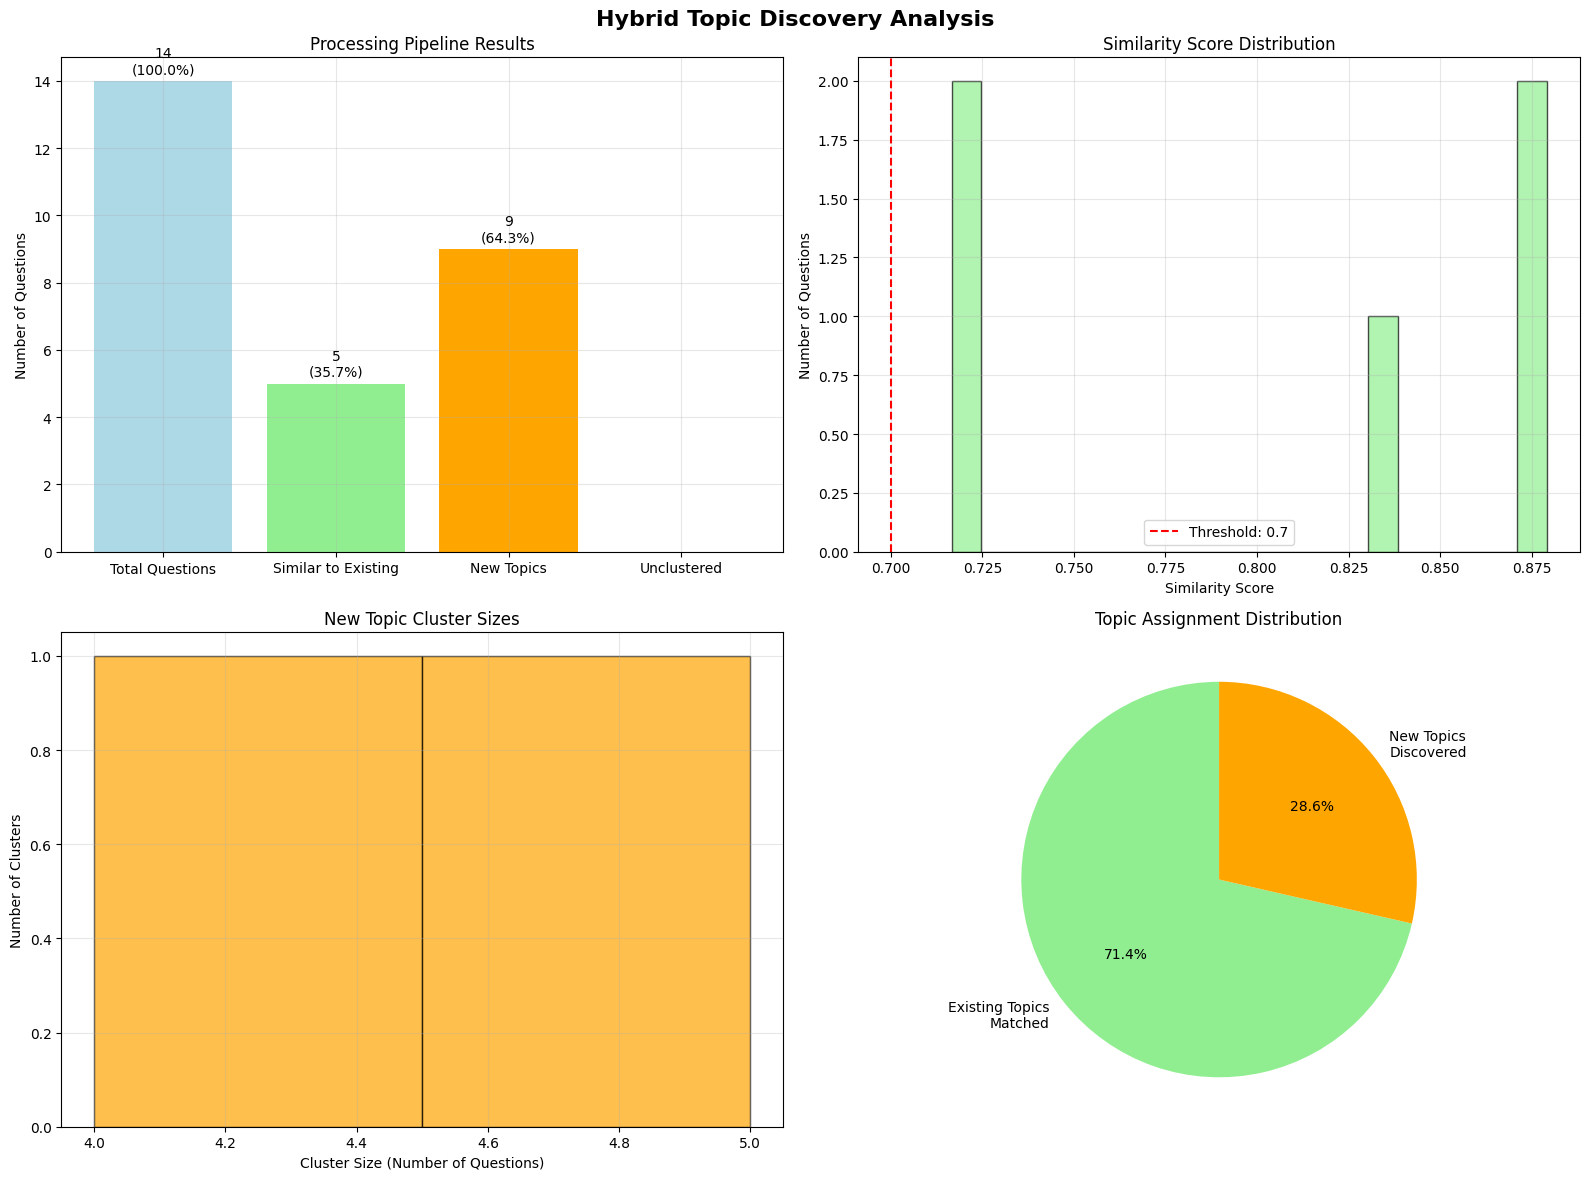


📊 DETAILED ANALYSIS:

🎯 SIMILARITY ANALYSIS:
   Questions matching existing topics: 5
   Average similarity score: 0.804
   Similarity range: 0.717 - 0.879
   Most frequently matched topics:
     - New Student: 2 questions
     - Gathering: 1 questions
     - Student Gathering Transfer: 1 questions
     - Continuing Student Registration: 1 questions

🆕 CLUSTERING ANALYSIS:
   New topics discovered: 2
   Questions in new topics: 9
   Average cluster size: 4.5 questions
   Largest cluster: 5 questions
   Smallest cluster: 4 questions

⚡ PERFORMANCE METRICS:
   Processing efficiency: 100.0%
   Similarity threshold effectiveness: 35.7%


In [ ]:
# ====================================================================
# ANALYSIS AND VISUALIZATION
# ====================================================================

def create_analysis_visualizations():
    """Create comprehensive analysis visualizations"""

    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Hybrid Topic Discovery Analysis', fontsize=16, fontweight='bold')

    # 1. Processing Pipeline Results
    pipeline_labels = ['Total Questions', 'Similar to Existing', 'New Topics', 'Unclustered']

    total_count = len(eval_questions_df)
    similar_count = len(similar_questions_df)
    new_topics_count = len(clustered_questions_df) if clustered_questions_df is not None else 0
    unclustered_count = total_count - similar_count - new_topics_count

    pipeline_counts = [total_count, similar_count, new_topics_count, unclustered_count]
    colors = ['lightblue', 'lightgreen', 'orange', 'lightcoral']

    bars = axes[0,0].bar(pipeline_labels, pipeline_counts, color=colors)
    axes[0,0].set_title('Processing Pipeline Results')
    axes[0,0].set_ylabel('Number of Questions')

    # Add percentage labels on bars
    for bar, count in zip(bars, pipeline_counts):
        height = bar.get_height()
        if height > 0:
            percentage = (count / total_count) * 100
            axes[0,0].text(bar.get_x() + bar.get_width()/2., height + total_count*0.01,
                          f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')

    axes[0,0].grid(True, alpha=0.3)

    # 2. Similarity Score Distribution
    if len(similar_questions_df) > 0:
        axes[0,1].hist(similar_questions_df['similarity_score'], bins=20, alpha=0.7,
                      color='lightgreen', edgecolor='black')
        axes[0,1].axvline(SIMILARITY_THRESHOLD, color='red', linestyle='--',
                         label=f'Threshold: {SIMILARITY_THRESHOLD}')
        axes[0,1].set_xlabel('Similarity Score')
        axes[0,1].set_ylabel('Number of Questions')
        axes[0,1].set_title('Similarity Score Distribution')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
    else:
        axes[0,1].text(0.5, 0.5, 'No similar questions found',
                      ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Similarity Score Distribution')

    # 3. Cluster Size Distribution
    if clustered_questions_df is not None and len(clustered_questions_df) > 0:
        cluster_sizes = clustered_questions_df['cluster_id'].value_counts().values
        axes[1,0].hist(cluster_sizes, bins=min(20, len(cluster_sizes)), alpha=0.7,
                      color='orange', edgecolor='black')
        axes[1,0].set_xlabel('Cluster Size (Number of Questions)')
        axes[1,0].set_ylabel('Number of Clusters')
        axes[1,0].set_title('New Topic Cluster Sizes')
        axes[1,0].grid(True, alpha=0.3)
    else:
        axes[1,0].text(0.5, 0.5, 'No clusters found',
                      ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('New Topic Cluster Sizes')

    # 4. Processing Efficiency
    efficiency_labels = ['Existing Topics\nMatched', 'New Topics\nDiscovered']
    efficiency_values = [
        len(similar_questions_df) if len(similar_questions_df) > 0 else 0,
        len(topic_names) if len(topic_names) > 0 else 0
    ]

    if sum(efficiency_values) > 0:
        axes[1,1].pie(efficiency_values, labels=efficiency_labels, autopct='%1.1f%%',
                     colors=['lightgreen', 'orange'], startangle=90)
        axes[1,1].set_title('Topic Assignment Distribution')
    else:
        axes[1,1].text(0.5, 0.5, 'No topics assigned',
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Topic Assignment Distribution')

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print(f"\n📊 DETAILED ANALYSIS:")
    print(f"="*60)

    print(f"\n🎯 SIMILARITY ANALYSIS:")
    if len(similar_questions_df) > 0:
        print(f"   Questions matching existing topics: {len(similar_questions_df)}")
        print(f"   Average similarity score: {similar_questions_df['similarity_score'].mean():.3f}")
        print(f"   Similarity range: {similar_questions_df['similarity_score'].min():.3f} - {similar_questions_df['similarity_score'].max():.3f}")

        # Top matched topics
        top_topics = similar_questions_df['matched_topic'].value_counts().head(5)
        print(f"   Most frequently matched topics:")
        for topic, count in top_topics.items():
            print(f"     - {topic}: {count} questions")
    else:
        print(f"   No questions matched existing topics (threshold: {SIMILARITY_THRESHOLD})")

    print(f"\n🆕 CLUSTERING ANALYSIS:")
    if clustered_questions_df is not None and len(clustered_questions_df) > 0:
        print(f"   New topics discovered: {len(topic_names)}")
        print(f"   Questions in new topics: {len(clustered_questions_df)}")
        cluster_sizes = clustered_questions_df['cluster_id'].value_counts()
        print(f"   Average cluster size: {cluster_sizes.mean():.1f} questions")
        print(f"   Largest cluster: {cluster_sizes.max()} questions")
        print(f"   Smallest cluster: {cluster_sizes.min()} questions")
    else:
        print(f"   No new topics discovered through clustering")

    print(f"\n⚡ PERFORMANCE METRICS:")
    print(f"   Processing efficiency: {((len(similar_questions_df) + (len(clustered_questions_df) or 0)) / len(eval_questions_df) * 100):.1f}%")
    print(f"   Similarity threshold effectiveness: {(len(similar_questions_df) / len(eval_questions_df) * 100):.1f}%")

# Create analysis visualizations
create_analysis_visualizations()

## Configuration Summary & Next Steps

In [ ]:
# ====================================================================
# CONFIGURATION SUMMARY & NEXT STEPS
# ====================================================================

def print_configuration_summary():
    """Print a comprehensive summary of the configuration and results"""

    print(f"\n🔧 CONFIGURATION SUMMARY:")
    print(f"="*60)
    print(f"Processing Mode: {EVAL_MODE.upper()}")
    print(f"Sample Size: {SAMPLE_SIZE if EVAL_MODE == 'sample' else 'ALL'}")
    print(f"Similarity Threshold: {SIMILARITY_THRESHOLD}")
    print(f"Representative Question Method: {REPRESENTATIVE_QUESTION_METHOD}")
    print(f"Embedding Model: {EMBEDDING_MODEL}")
    print(f"GPT Model: {GPT_MODEL}")
    print(f"Random Seed: {RANDOM_SEED}")
    print(f"Caching: {'ENABLED' if CACHE_EMBEDDINGS else 'DISABLED'}")

    print(f"\n📊 PROCESSING RESULTS:")
    print(f"="*60)
    print(f"Total Questions Processed: {len(eval_questions_df)}")
    print(f"Similar to Existing Topics: {len(similar_questions_df)} ({len(similar_questions_df)/len(eval_questions_df)*100:.1f}%)")

    if clustered_questions_df is not None:
        print(f"New Topics Discovered: {len(topic_names)} topics covering {len(clustered_questions_df)} questions")
    else:
        print(f"New Topics Discovered: 0 (no clustering performed)")

    print(f"\n📁 OUTPUT FILES:")
    print(f"="*60)
    print(f"1. {output_files[0]}")
    print(f"   - Questions matching existing topics (≥{SIMILARITY_THRESHOLD} similarity)")
    print(f"   - Format: question, existing_topic, existing_subtopic, similarity_score")
    print(f"   - Count: {len(similar_questions_df)} questions")

    print(f"\n2. {output_files[1]}")
    print(f"   - New topics for Elder Edwards' review")
    print(f"   - Format: topic_name, representative_question, question_count")
    print(f"   - Count: {len(topic_names)} new topics")

    print(f"\n3. {output_files[2]}")
    print(f"   - Pathway questions review (all questions with topic assignments)")
    print(f"   - Format: question, topic_name")
    print(f"   - Includes questions under 'Other' topic (unclustered questions)")
    print(f"   - Count: All processed questions")

    print(f"\n💡 RECOMMENDATIONS FOR ELDER EDWARDS:")
    print(f"="*60)

    if len(similar_questions_df) > 0:
        print(f"✅ Review similar_questions file:")
        print(f"   - {len(similar_questions_df)} questions matched existing topics")
        print(f"   - Consider if similarity scores are appropriate")
        print(f"   - Verify topic assignments make sense")

    if len(topic_names) > 0:
        print(f"\n✅ Review new_topics file:")
        print(f"   - {len(topic_names)} new topics discovered")
        print(f"   - Consider adding promising topics to topic-questions.csv")
        print(f"   - Review representative questions for clarity")

        # Show largest clusters for immediate attention
        if clustered_questions_df is not None:
            largest_clusters = clustered_questions_df['cluster_id'].value_counts().head(3)
            print(f"\n   Priority topics (largest clusters):")
            for cluster_id, size in largest_clusters.items():
                topic_name = topic_names.get(cluster_id, f"Cluster_{cluster_id}")
                print(f"     - \"{topic_name}\" ({size} questions)")

    if len(similar_questions_df) == 0 and len(topic_names) == 0:
        print(f"⚠️  No topics discovered:")
        print(f"   - Consider lowering similarity threshold (current: {SIMILARITY_THRESHOLD})")
        print(f"   - Check if existing topic-questions.csv covers the domain well")
        print(f"   - Verify new questions are in the expected domain")

    print(f"\n🔄 NEXT ITERATION SUGGESTIONS:")
    print(f"="*60)
    print(f"1. Adjust SIMILARITY_THRESHOLD based on results")
    print(f"2. Add approved new topics to topic-questions.csv")
    print(f"3. Re-run with EVAL_MODE='all' for full dataset")
    print(f"4. Fine-tune clustering parameters if needed")

# Print comprehensive summary
print_configuration_summary()

print(f"\n🎉 HYBRID TOPIC DISCOVERY COMPLETE!")
print(f"Ready for Elder Edwards' review and feedback.")


🔧 CONFIGURATION SUMMARY:
Processing Mode: SAMPLE
Sample Size: 1000
Similarity Threshold: 0.7
Representative Question Method: centroid
Embedding Model: text-embedding-3-small
GPT Model: gpt-5-nano
Random Seed: 42
Caching: ENABLED

📊 PROCESSING RESULTS:
Total Questions Processed: 14
Similar to Existing Topics: 5 (35.7%)
New Topics Discovered: 2 topics covering 9 questions

📁 OUTPUT FILES:
1. similar_questions_20251008_045720.csv
   - Questions matching existing topics (≥0.7 similarity)
   - Format: question, existing_topic, existing_subtopic, similarity_score
   - Count: 5 questions

2. new_topics_20251008_045720.csv
   - New topics for Elder Edwards' review
   - Format: topic_name, representative_question, question_count
   - Count: 2 new topics

3. pathway_questions_review_20251008_045720.csv
   - Pathway questions review (all questions with topic assignments)
   - Format: question, topic_name
   - Includes questions under 'Other' topic (unclustered questions)
   - Count: All processe

In [ ]:
# ====================================================================
# PRINT ERROR LOG SUMMARY
# ====================================================================

# Print comprehensive error log summary
error_logger.print_summary()

print(f"\n🎉 HYBRID TOPIC DISCOVERY COMPLETE!")
print(f"📋 Ready for review with comprehensive error logging.")